In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder,LabelBinarizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score,precision_recall_fscore_support,f1_score
from sklearn.metrics import classification_report
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
from pandas.tools.plotting import parallel_coordinates
from math import pi

In [2]:
wine_base = pd.read_csv("Our_dataset/StemmedWord2vecTop3_parsed.csv", index_col=0) 
wine_base = wine_base.reset_index()
wine_base= wine_base[pd.notnull(wine_base['description'])]
wine_base.columns

for col in wine_base.columns:
    if(col.startswith("tf")):
            wine_base.drop(col,inplace=True,axis=1)

import re
def get_vintage(df):
    pattern = r"\d{4}"
    vintages = []
    for elem in df.title:
        match = re.findall(pattern,elem)
        year = 0
        if len(match)>1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif y == 7200:
                year = int(match[1])
            else:
                year= y
        elif len(match)==1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif year == 7200:
                year = 0
            else:
                year = y
        else:
            year = 0
        vintages.append(year)

    se = pd.Series(vintages)
    df['vintage']=se.values 
    df.drop('title',axis=1)
    return df

wine_base = get_vintage(wine_base)
#drop reviwe of wine with ventage =0
wine_base = wine_base[wine_base.vintage != 0]

wine_base = wine_base[pd.notnull(wine_base['country'])]
wine_base = wine_base[pd.notnull(wine_base['taster_name'])]
wine_base = wine_base[pd.notnull(wine_base["variety"])]
wine_base = wine_base[pd.notnull(wine_base["province"])]
wine_base = wine_base[pd.notnull(wine_base["winery"])]

wine_base.drop("title",inplace=True,axis=1)
wine_base = wine_base.dropna()

#keep track of the countries,provinces,taster_names in the database
countries = wine_base["country"].unique().tolist()
provinces = wine_base["province"].unique().tolist()
tasters = wine_base["taster_name"].unique().tolist()

def OneHotEncode(dataframe,column_to_encode,take_whole_dataset=True):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(dataframe[[column_to_encode]])
    mapping = {}
    i=0
    for elem in enc.categories_[0]:
        mapping[elem]=i
        i+=1
    resu = enc.transform(dataframe[[column_to_encode]]).toarray()
    if take_whole_dataset:
        for elem in mapping:
            dataframe[elem]=resu[:,mapping[elem]]
        return dataframe
    else:
        subset = dataframe[[column_to_encode]]
        for elem in mapping:
            subset[elem]=resu[:,mapping[elem]]
        return subset
    
wine_base = OneHotEncode(wine_base,'taster_name')
wine_base = wine_base.drop('taster_name', 1)
wine_base = OneHotEncode(wine_base,'province')
wine_base = wine_base.drop('province', 1)
wine_base.drop(["designation","description"],axis=1,inplace=True)

lb = LabelBinarizer()

wine_base["winery"] = wine_base["winery"].astype('category').cat.codes
wine_base["region_1"] = wine_base["region_1"].astype('category').cat.codes
wine_base["variety"] = wine_base["variety"].astype('category').cat.codes
wine_base

,country,points,price,region_1,variety,winery,similarityTop3WinesByVariety,word_count,vintage,Alexander Peartree,...,Washington-Oregon,Weinland Österreich,Weinviertel,Wellington,Western Australia,Western Cape,Wiener Gemischter Satz,Württemberg,Österreichischer Perlwein,Österreichischer Sekt
0,Italy,87,17.000000,419,597,10992,1.142944,10,2013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Portugal,87,15.000000,1207,385,12258,1.078157,6,2011,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,US,87,14.000000,1195,373,12319,1.156945,10,2013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,US,87,13.000000,541,409,13618,1.025862,13,2013,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,US,87,65.000000,1195,377,13831,1.192760,16,2012,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Spain,87,15.000000,743,508,13910,0.648527,17,2011,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Italy,87,16.000000,1182,163,14206,0.963839,10,2013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,France,87,24.000000,21,185,14564,1.094184,8,2012,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Germany,87,12.000000,1207,185,8007,1.050787,12,2013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,France,87,27.000000,21,373,8547,1.043785,11,2012,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


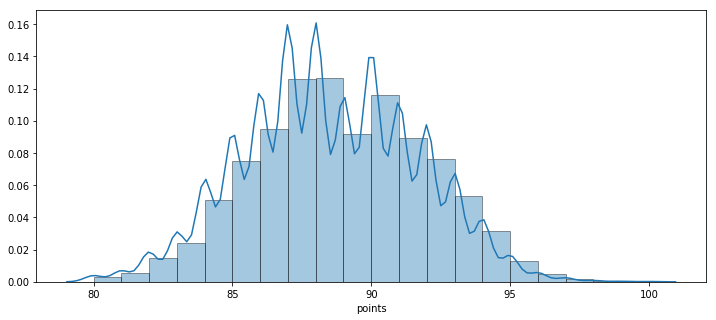

In [3]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.distplot(wine_base["points"],hist=True,bins = 20,hist_kws={'edgecolor':'black'})

wine2 = pd.DataFrame()
wine2 = wine_base
nbins  = 3
labels=["low","medium","high"]
g,b = pd.qcut(wine2["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
g.tolist()
wine2["category"] = g

wine2.drop("description",axis=1,inplace=True)

parallel coordinates would be nice

low = wine2[wine2["category"] == "low"]
medium = wine2[wine2["category"] == "medium"]
high = wine2[wine2["category"] == "high"]

wine3 = pd.DataFrame()
features = ["category",'vintage', 'country', 'points', 'price', 'province','region_1', 'taster_name', 'variety', 'winery','similarityTop3WinesByVariety', 'word_count']
for feat in features:
    wine3[feat] = wine2[feat]
fig, ax = plt.subplots(figsize = (25, 10))
parallel_coordinates(wine3, 'category', colormap=plt.get_cmap("Set2"))
plt.show()

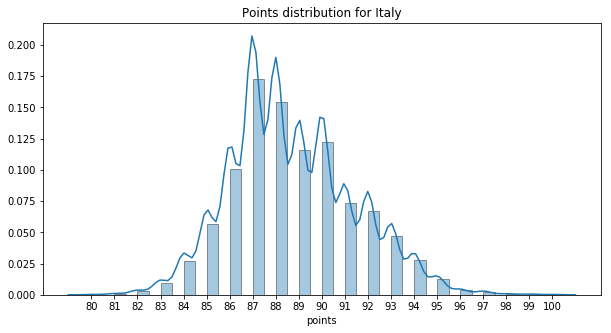

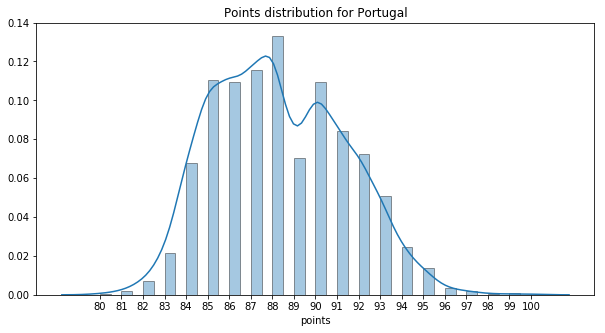

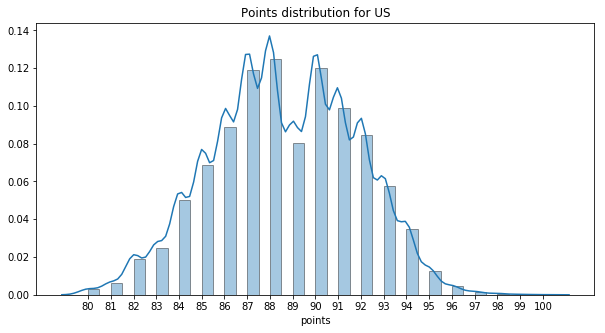

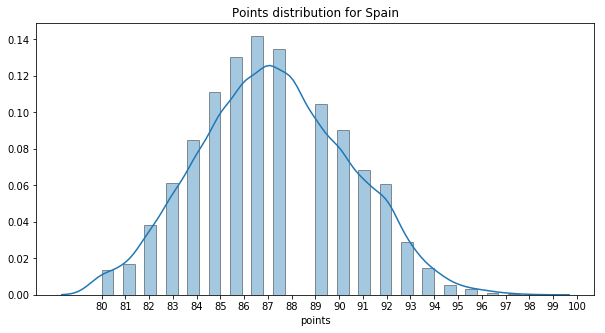

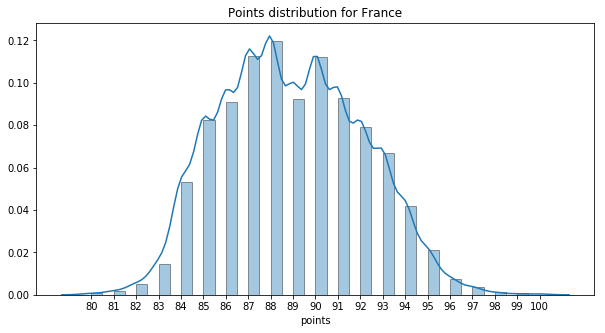

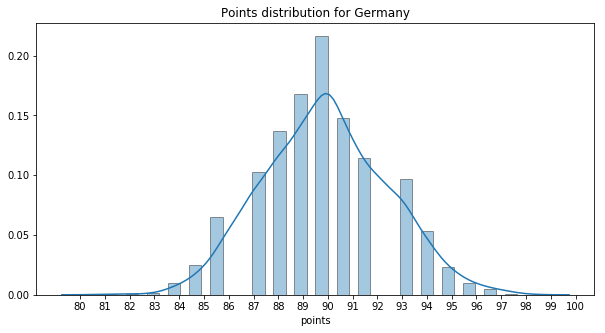

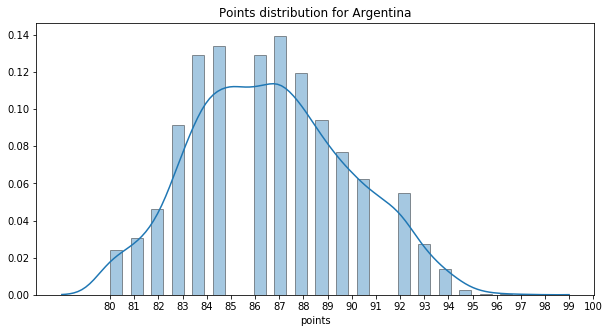

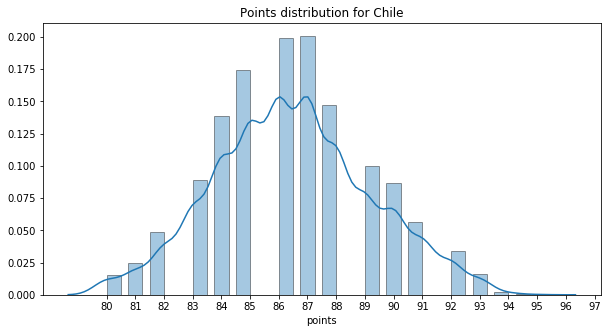

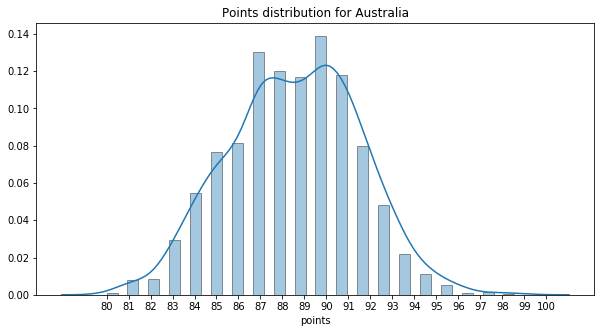

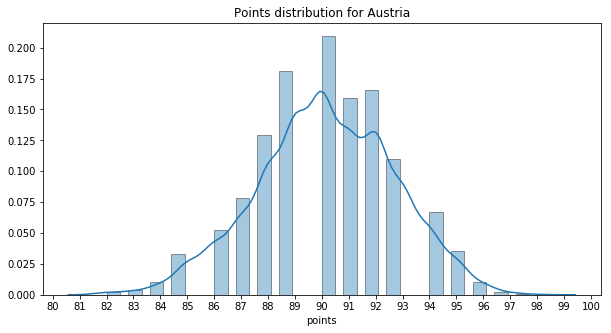

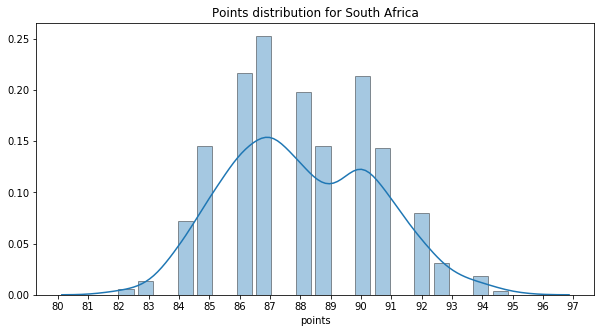

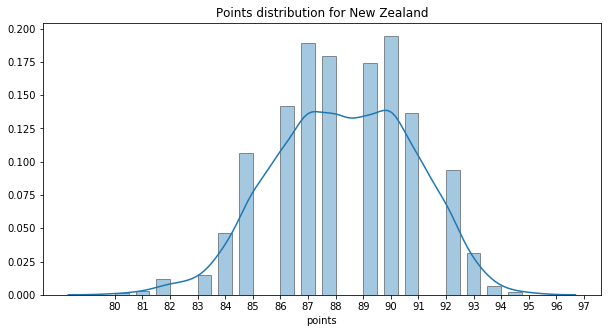

In [4]:
countries = wine_base["country"].unique().tolist()
for c in countries:
    fig, ax = plt.subplots(figsize = (10, 5))
    temp = wine_base[wine_base["country"] == c]
    plt.title("Points distribution for " + c)
    ax.set(xticks=wine_base["points"].unique())
    sns.distplot(temp["points"],hist=True,bins = 20,hist_kws={"width": 0.5,'edgecolor':'black'})
    sns

In [ ]:
countries = wine_base["country"].unique().tolist()
for c in countries:
    fig, ax = plt.subplots(figsize = (10, 5))
    temp = wine_base[wine_base["country"] == c]
    plt.title("Price distribution for " + c)
    sns.distplot(temp["price"],hist=True)
    sns

# DEFINE NUMBER OF BINS = classes to be predicted (must be executed so that Y is the same for every execution)

10.0


<module 'seaborn' from 'E:\\Anaconda\\lib\\site-packages\\seaborn\\__init__.py'>

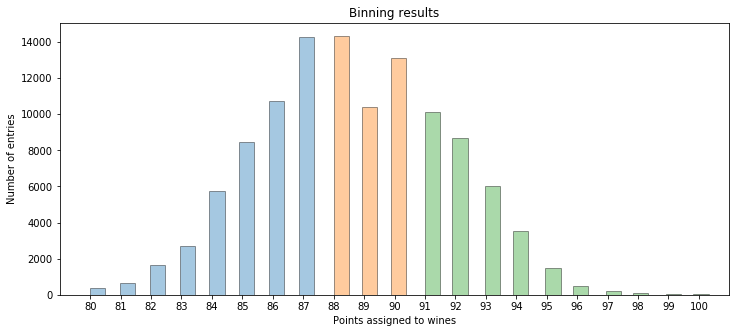

In [5]:
Y = wine_base['points'].copy()
#DECIDE NUMBER OF BINS 
#nbins  = 4
#labels=["low","medium","high","very_high"]
#nbins = 5
#labels=["very_low", "low", "medium","high","very_high"]
#bin identici 
#Y,bins = pd.cut(Y,nbins,labels=labels,retbins=True,include_lowest=True,right=True)
#quartile
nbins  = 3
labels=["low","medium","high"]
Y,bins = pd.qcut(Y,nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
values = Y.tolist()  

#plot the binning result
fig, ax = plt.subplots(figsize = (12, 5))
for i in range(1,len(bins)-1):

    if i == 1:
        a = wine_base[wine_base["points"] <= bins[i]]
        n =  bins[i]-80
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+n
    if i == len(bins)-1:
        a = wine_base[wine_base["points"] > bins[i]]
        n = 100 - bins[i]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+ n
    else:
        n = bins[i+1] - bins[i]
        g =+n
        a = wine_base[(wine_base["points"] > bins[i]) & (wine_base["points"] <= bins[i+1])]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
ax.set(xticks=wine_base["points"].unique())
plt.ylabel("Number of entries")
plt.xlabel("Points assigned to wines")
plt.title("Binning results")
print(g)
sns

In [6]:
basic = ["price",'vintage', 'country', 'province', 'region_1', 'taster_name', 'variety','winery']
word = ["word_count"]
#tfGroup = ['tf_grouped_1','tf_grouped_2', 'tf_grouped_3']
#tfIdfGroup = ['tfIdf_grouped_1', 'tfIdf_grouped_2', 'tfIdf_grouped_3']
#tfFull = ['tf_fullData_1', 'tf_fullData_2', 'tf_fullData_3',]
#tfIdfFull = ['tfIdf_fullData_1', 'tfIdf_fullData_2', 'tfIdf_fullData_3']
#weather = ['pr_5', 'pr_6', 'pr_7', 'pr_8', 'pr_9', 'tas_5', 'tas_6', 'tas_7', 'tas_8', 'tas_9']# don't really care bcs 0 improvements
word2vec = ['similarityTop3WinesByVariety']
features = basic + word + word2vec

# test stuff based on countries

In [7]:
countries = wine_base["country"].unique().tolist()
countries
for c in countries:
    print(c,len(wine_base[wine_base["country"] == c]))
test = wine_base["country"].unique().tolist()
test

Italy 16965
Portugal 4950
US 49529
Spain 5637
France 18906
Germany 1978
Argentina 3495
Chile 4159
Australia 2130
Austria 2996
South Africa 1284
New Zealand 1268


['Italy',
 'Portugal',
 'US',
 'Spain',
 'France',
 'Germany',
 'Argentina',
 'Chile',
 'Australia',
 'Austria',
 'South Africa',
 'New Zealand']

In [8]:
def testByCountry(data,countries):
    #for every country, use it as test set
    nbins  = 3
    labels=["low","medium","high"]
    wine2 = pd.DataFrame()
    wine2 = data
    g,b = pd.qcut(data["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
    g.tolist()
    wine3 = wine2.drop(["points"],axis=1)
    wine3["category"] = g
    df = pd.DataFrame()
    for el in countries:
        res = applyTest(wine3,el)
        df = df.append(res)
    return df

def applyTest(data,objCountry):
  
    #set many different combinations
    #only on these
    allfeatures = []
    args = []
    for el in wine_base.columns:
        if el != "description":
            allfeatures.append(el)   
        if el != "description" and el != "points" and el != "country":
            args.append(el)
    combos = {"depth":[2,3,4,5,6],"args":[args]}
    #
    res = buildCountryResult(data,args,allfeatures,combos,objCountry)
    return res

def buildCountryResult(data,args,allfeatures,combination,objCountry):
    cols = ["algorithm","ObjectiveCountry","input","precision","accuracy","f1","depth"]
    algorithm = "decTree"
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in args: #controlla che allfeats vada bene
        c = "feat_"+el
        if c not in cols:
            cols.append(c)
    results = pd.DataFrame()
    comb = 0
    row = 0
    for el in combination["args"]: 
        el = el + ["country","category"]
        X = data[el]
        #create test and training sets
        X_train = X[X["country"] != objCountry]
        y_train = pd.DataFrame()
        #obbiettivo è la categoria del dataframe X_train perchè è quello che contiene le righe giuste per le country
        y_train = list(X_train["category"])
        print(objCountry +" must not be in training set " + str(X_train["country"].unique().tolist()))
        X_train.drop(["country","category"],axis=1,inplace=True)

        X_test = X[X["country"] == objCountry]
        y_test = X_test["category"]
        X_test.drop(["country","category"],axis=1,inplace=True)
        for depth in combination["depth"]:
                row = row + 1  
                #train stuff
                classifier = DecisionTreeClassifier(max_depth=depth)
                classifier.fit(X_train,y_train)
                y_pred = classifier.predict(X_test)  
                acc = accuracy_score(y_test,y_pred)#average="macro")
                weightedPrec = precision_score(y_test,y_pred,average="weighted")
                f1 = f1_score(y_test,y_pred,average="weighted")
                rowData = [algorithm,objCountry,el,weightedPrec,acc,f1,depth]
                precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
                for i in range(0,len(labels)):
                    rowData.append(precision[i])
                    rowData.append(recall[i])
                    rowData.append(fscore[i])
                    rowData.append(support[i])
                    temp = {}
                c = zip(el,classifier.feature_importances_)
                names = []
                for name,importance in c:
                    temp[name] = importance
                    names.append(name)
                for feat in names:
                    #if feat not in allfeatures:
                     #   rowData.append(100) #100 is an impossible value not to be taken into account
                    #else:
                        rowData.append(temp[feat]) #qualcosa non quadra con le liste di input e colonne per appendere i dataframe con le relative feature importances
                df2 = pd.DataFrame([rowData],columns=cols)
                results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [9]:
basic = ["price",'vintage', 'province', 'region_1', 'taster_name', 'variety','winery'] #country non deve esserci 
word = ["word_count"]
word2vec = ['similarityTop3WinesByVariety']
features = []
for el in wine_base.columns:
    if el != "description":
        features.append(el)

result = testByCountry(wine_base,countries)
len(result.columns.tolist())
result.drop("input",inplace=True,axis=1)
result

Italy must not be in training set ['Portugal', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
Portugal must not be in training set ['Italy', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
US must not be in training set ['Italy', 'Portugal', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
Spain must not be in training set ['Italy', 'Portugal', 'US', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
France must not be in training set ['Italy', 'Portugal', 'US', 'Spain', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
Germany must not be in training set ['Italy', 'Portugal', 'US', 'Spain', 'France', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']
Argentina must not be in training set ['

,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,low_support,...,feat_Washington-Oregon,feat_Weinland Österreich,feat_Weinviertel,feat_Wellington,feat_Western Australia,feat_Western Cape,feat_Wiener Gemischter Satz,feat_Württemberg,feat_Österreichischer Perlwein,feat_Österreichischer Sekt
0,decTree,Italy,0.540875,0.551253,0.534641,2,0.536900,0.653280,0.589400,4009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,decTree,Italy,0.558822,0.532449,0.518109,3,0.452237,0.879771,0.597392,4009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,decTree,Italy,0.593272,0.565871,0.563017,4,0.516491,0.792966,0.625541,4009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,decTree,Italy,0.586953,0.573946,0.569871,5,0.516485,0.793215,0.625615,4009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,decTree,Italy,0.581607,0.556027,0.550885,6,0.477010,0.822898,0.603936,4009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000470
0,decTree,Portugal,0.541997,0.508081,0.442017,2,0.849802,0.172138,0.286285,1249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,decTree,Portugal,0.600678,0.589899,0.565494,3,0.791171,0.373098,0.507073,1249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,decTree,Portugal,0.598279,0.579596,0.552366,4,0.797980,0.316253,0.452982,1249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,decTree,Portugal,0.598447,0.580404,0.552089,5,0.799189,0.315452,0.452354,1249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,decTree,Portugal,0.616331,0.593131,0.576133,6,0.790960,0.336269,0.471910,1249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000383


In [10]:
#if the column is never used delete it
for col in result.columns:
    if len(result[col].unique().tolist()) == 1 and col != "algorithm":
        result.drop(col,inplace=True,axis=1)
len(result.columns)

46

In [11]:
#since there are combinations of country/depth for every country, if we take the first row every 5 we have the best result
result = result.sort_values(["ObjectiveCountry","f1"],ascending=False)
df = pd.DataFrame()
df = result.reset_index(drop=True)    
df = df.iloc[::5, :]
df

,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,low_support,...,feat_Austria,feat_Baden,feat_California,feat_Kamptal,feat_New York,feat_Northeastern Italy,feat_Northern Spain,feat_Südsteiermark,feat_Washington,feat_Österreichischer Sekt
0,decTree,US,0.578296,0.554483,0.560891,6,0.582740,0.598347,0.590440,14637,...,0.000154,0.000742,0.000000,0.000287,0.000000,0.0,0.0,0.000000,0.000000,0.000000
5,decTree,Spain,0.690139,0.651943,0.663278,4,0.608974,0.616216,0.612574,925,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
10,decTree,South Africa,0.688041,0.678349,0.681595,4,0.610487,0.705628,0.654618,231,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
15,decTree,Portugal,0.616331,0.593131,0.576133,6,0.790960,0.336269,0.471910,1249,...,0.000000,0.000000,0.001949,0.000000,0.000000,0.0,0.0,0.000048,0.000000,0.000383
20,decTree,New Zealand,0.553157,0.552050,0.552515,3,0.556818,0.571984,0.564299,257,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
25,decTree,Italy,0.586953,0.573946,0.569871,5,0.516485,0.793215,0.625615,4009,...,0.000000,0.000000,0.015395,0.000000,0.000000,0.0,0.0,0.000000,0.000908,0.000000
30,decTree,Germany,0.603794,0.571790,0.577144,6,0.750936,0.529024,0.620743,758,...,0.000000,0.000000,0.000362,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000234
35,decTree,France,0.618510,0.578917,0.587323,5,0.727654,0.610981,0.664233,5956,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.001047,0.000000
40,decTree,Chile,0.757597,0.720846,0.733832,4,0.531486,0.622419,0.573370,339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
45,decTree,Austria,0.587857,0.533044,0.545578,6,0.768332,0.548558,0.640106,1318,...,0.000000,0.000000,0.000366,0.000000,0.000118,0.0,0.0,0.000000,0.000850,0.000000


# Analyse general country stuff

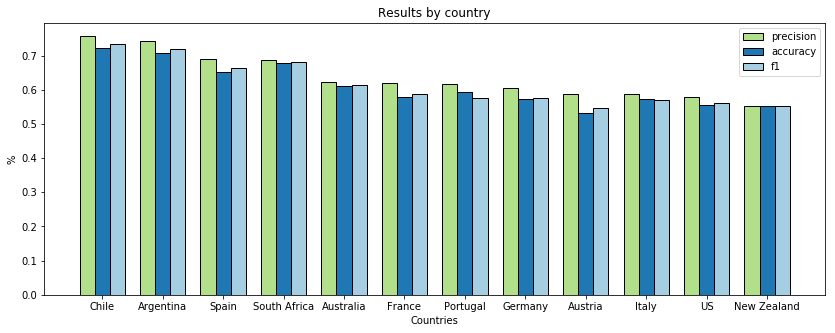

In [12]:
#plot accuracy, precision, f1 for every country (f1=weighted average of precision, recall)
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","precision","accuracy","f1"]]
temp = temp.sort_values(["precision","f1","accuracy"],ascending=False)
# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["precision"]
# Choose the height of the cyan bars
bars2 = temp["accuracy"]

bars3 = temp["f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#b2df8a", edgecolor = 'black', capsize=7, label='precision')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#1f78b4', edgecolor = 'black', capsize=7, label='accuracy')

plt.bar(r3, bars3, width = barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7, label='f1')

xs = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], xs)
plt.title("Results by country")
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
 
# Show graphic
plt.show()


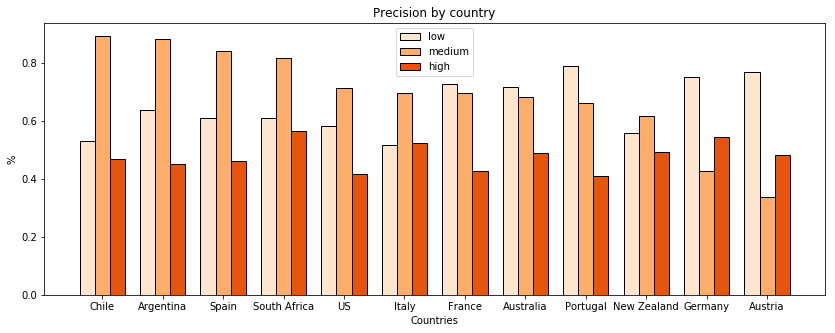

In [13]:

#plot f1 by category predicted 
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","low_prec","medium_prec","high_prec"]]
temp = temp.sort_values(["medium_prec","high_prec","low_prec"],ascending=False)
temp

# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["low_prec"]
# Choose the height of the cyan bars
bars2 = temp["medium_prec"]

bars3 = temp["high_prec"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#fee6ce", edgecolor = 'black', capsize=7, label='low')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#fdae6b', edgecolor = 'black', capsize=7, label='medium')

plt.bar(r3, bars3, width = barWidth, color = "#e6550d", edgecolor = 'black', capsize=7, label='high')

ys = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ys)
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
plt.title("Precision by country") 
# Show graphic
plt.show()

# Per country, visualize  what influences the decision tree 
IT DOESN'T TAKE INTO ACCOUNT PRICE BECAUSE IT WOULD MAKE EVERY KIND OF VISUALIZATION USELESS

In [14]:
#take mean of all the features used in the computations of decision tree to see the by country and understand which factors play into a country 

features = []
for col in df.columns:
    if col.startswith("feat"):
        features.append(col)
print(features)

t1 = pd.DataFrame()
t = result.groupby("ObjectiveCountry")
for col in features: 
    t1[col] = t[col].mean() 
t1.reset_index(inplace=True)
t1

['feat_price', 'feat_region_1', 'feat_variety', 'feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Jim Gordon', 'feat_Joe Czerwinski', 'feat_Kerin O’Keefe', 'feat_Lauren Buzzeo', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown', 'feat_Austria', 'feat_Baden', 'feat_California', 'feat_Kamptal', 'feat_New York', 'feat_Northeastern Italy', 'feat_Northern Spain', 'feat_Südsteiermark', 'feat_Washington', 'feat_Österreichischer Sekt']


,ObjectiveCountry,feat_price,feat_region_1,feat_variety,feat_winery,feat_similarityTop3WinesByVariety,feat_word_count,feat_vintage,feat_Alexander Peartree,feat_Anna Lee C. Iijima,...,feat_Austria,feat_Baden,feat_California,feat_Kamptal,feat_New York,feat_Northeastern Italy,feat_Northern Spain,feat_Südsteiermark,feat_Washington,feat_Österreichischer Sekt
0,Argentina,0.789961,0.000000,0.000000,0.000079,0.016006,0.136926,0.000590,0.000000,0.000354,...,0.000000,0.000000,0.000568,0.000000,0.000024,0.000000,0.000000,0.00000,0.000329,0.000043
1,Australia,0.796686,0.000000,0.000000,0.000076,0.015367,0.132115,0.002535,0.000000,0.000353,...,0.000000,0.000000,0.000066,0.000000,0.000024,0.000000,0.000000,0.00000,0.000329,0.000047
2,Austria,0.803199,0.000000,0.000000,0.000077,0.016932,0.135612,0.001514,0.000000,0.000362,...,0.000000,0.000000,0.000073,0.000000,0.000024,0.000000,0.000000,0.00000,0.000351,0.000000
3,Chile,0.784899,0.002107,0.000000,0.000000,0.014667,0.142858,0.001982,0.000094,0.000000,...,0.000000,0.000000,0.000070,0.000000,0.000025,0.000000,0.000000,0.00000,0.000142,0.000048
4,France,0.708036,0.001327,0.000118,0.000089,0.026998,0.212873,0.005675,0.000000,0.000409,...,0.000000,0.000000,0.000316,0.000000,0.000000,0.000074,0.000092,0.00000,0.000406,0.000000
5,Germany,0.799124,0.000000,0.000000,0.000000,0.013912,0.136331,0.001393,0.000000,0.000024,...,0.000000,0.000000,0.000072,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000047
6,Italy,0.787792,0.000000,0.000192,0.000084,0.022238,0.132706,0.003733,0.000101,0.000369,...,0.000000,0.000000,0.009333,0.000000,0.000027,0.000000,0.000000,0.00000,0.000352,0.000094
7,New Zealand,0.797061,0.000000,0.000000,0.000076,0.015627,0.131842,0.001898,0.000000,0.000347,...,0.000000,0.000000,0.000073,0.000000,0.000023,0.000000,0.000000,0.00000,0.000336,0.000046
8,Portugal,0.757384,0.000017,0.000000,0.000000,0.012610,0.177901,0.000468,0.000000,0.000476,...,0.000000,0.000000,0.000390,0.000000,0.000000,0.000000,0.000000,0.00001,0.000000,0.000077
9,South Africa,0.795423,0.000000,0.000000,0.000075,0.016121,0.131440,0.001603,0.000000,0.000348,...,0.000000,0.000000,0.000556,0.000000,0.000000,0.000000,0.000000,0.00000,0.000325,0.000046


['feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown', 'feat_California', 'feat_New York', 'feat_Washington', 'feat_Österreichischer Sekt']
[0.8797548977283339, 0.09767680931395678, 0.541386771468829, 0.08177710773742607, 0.25771821244836857, 0.14845875605033798, 0.24430621612729933, 0.5005448591856141, 0.9498168473702502, 0.958576480127003, 0.06090383181904845, 0.9116169579763092, 0.8106340735356595, 0.4561525975880225]


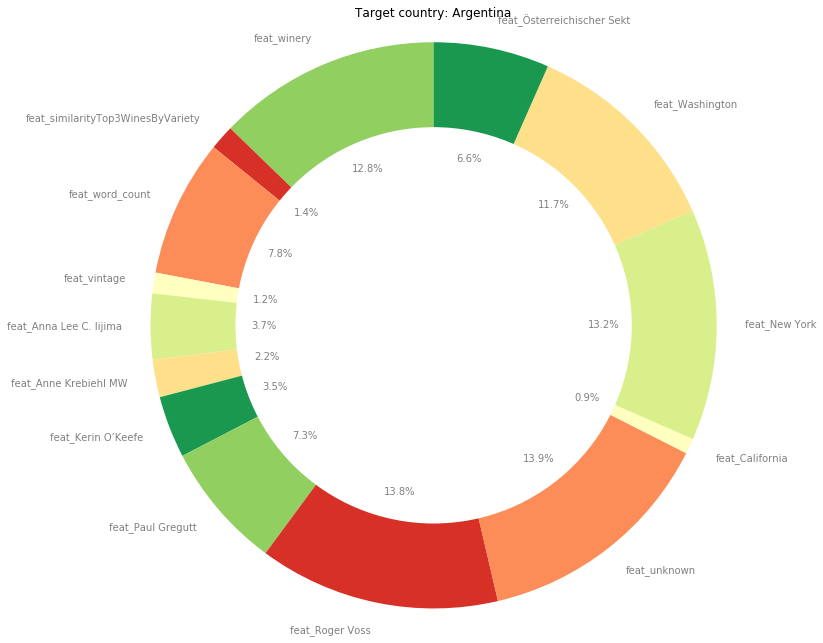

['feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown', 'feat_California', 'feat_New York', 'feat_Washington', 'feat_Österreichischer Sekt']
[0.8505539283066603, 0.07929666847445416, 0.5123358963491231, 0.4330267483026902, 0.2572264728604512, 0.14114299386286694, 0.19075006563895797, 0.1825526740746673, 0.5063927747265016, 0.9138151867107667, 0.8975582663184156, 0.007036711100141844, 0.8943753244766887, 0.8111775742673301, 0.4975858769597316]


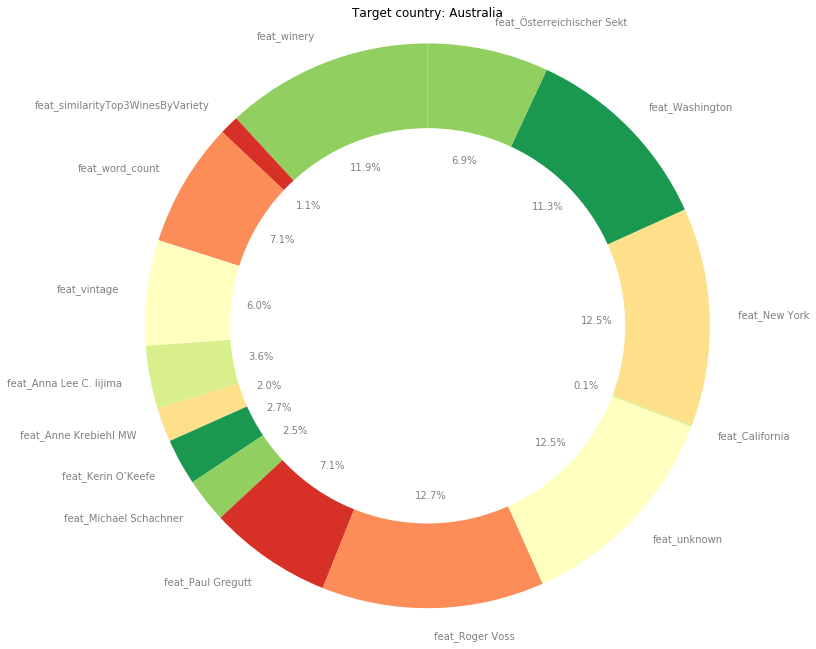

['feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Anna Lee C. Iijima', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown', 'feat_California', 'feat_New York', 'feat_Washington']
[0.8612769027859559, 0.12431118953164622, 0.5334527896658803, 0.24854283415890854, 0.2634436080744587, 0.14645555030810264, 0.32177289016959815, 0.5121444950150678, 0.8347877364471737, 0.7383209391146347, 0.007836798725396398, 0.8893405728747442, 0.8632137802622089]


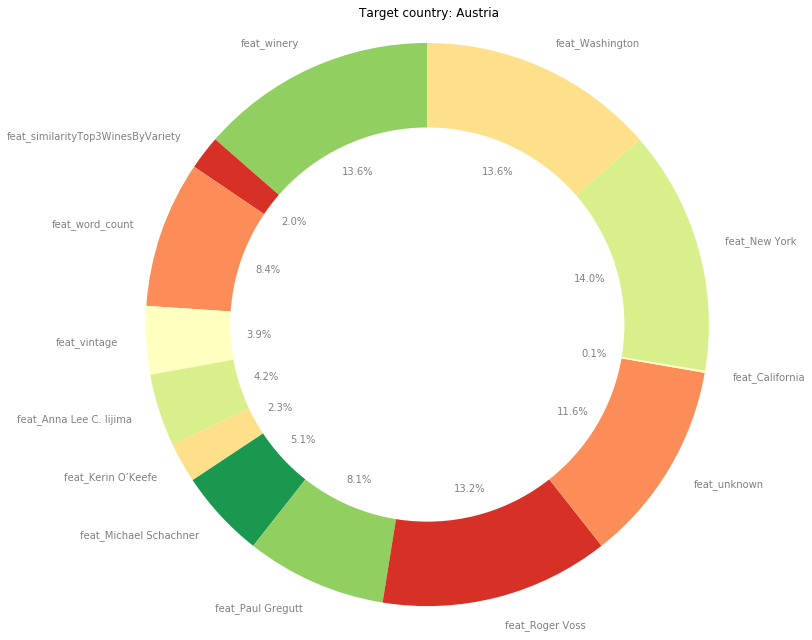

['feat_region_1', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anne Krebiehl\xa0MW', 'feat_Jim Gordon', 'feat_Kerin O’Keefe', 'feat_Lauren Buzzeo', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown', 'feat_California', 'feat_New York', 'feat_Washington', 'feat_Österreichischer Sekt']
[1.0, 0.059154423942290535, 0.5772036018291642, 0.3332041364867091, 0.9314148348564248, 0.0825589313558545, 1.0, 0.20035549343204975, 1.0, 0.18522950927631454, 0.9283960321239266, 0.98801976797908, 0.007493178914374366, 0.921336342559472, 0.3502561904549731, 0.5145813065789555]


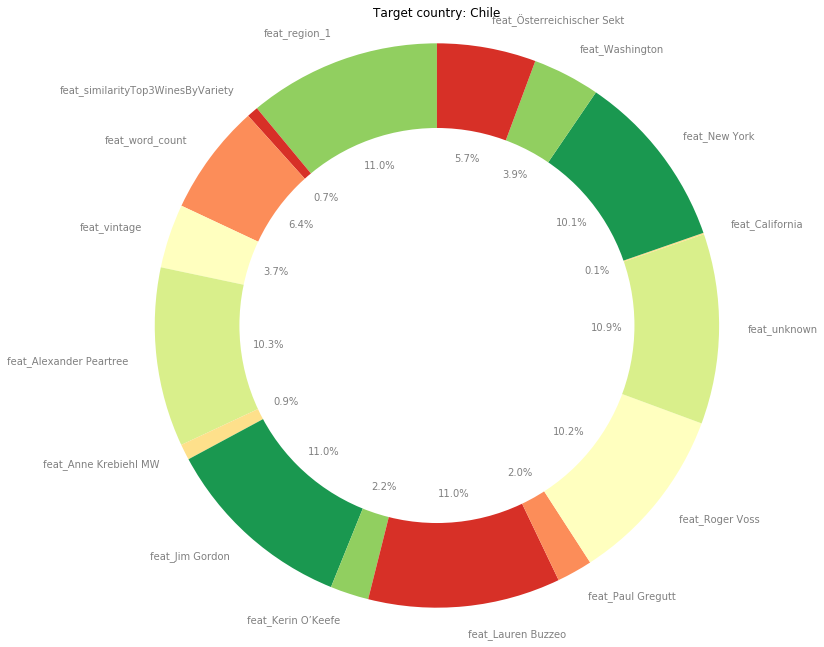

['feat_region_1', 'feat_variety', 'feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_unknown', 'feat_California', 'feat_Northeastern Italy', 'feat_Northern Spain', 'feat_Washington']
[0.6298900187589057, 0.6162972890283231, 0.9999999999999999, 0.413836749529238, 1.0, 1.0, 0.2975517982537584, 0.1144814283804605, 0.43162757346089686, 0.07715770010033497, 0.5739644827210987, 0.8858201076552557, 0.033830066537312686, 1.0, 1.0, 1.0]


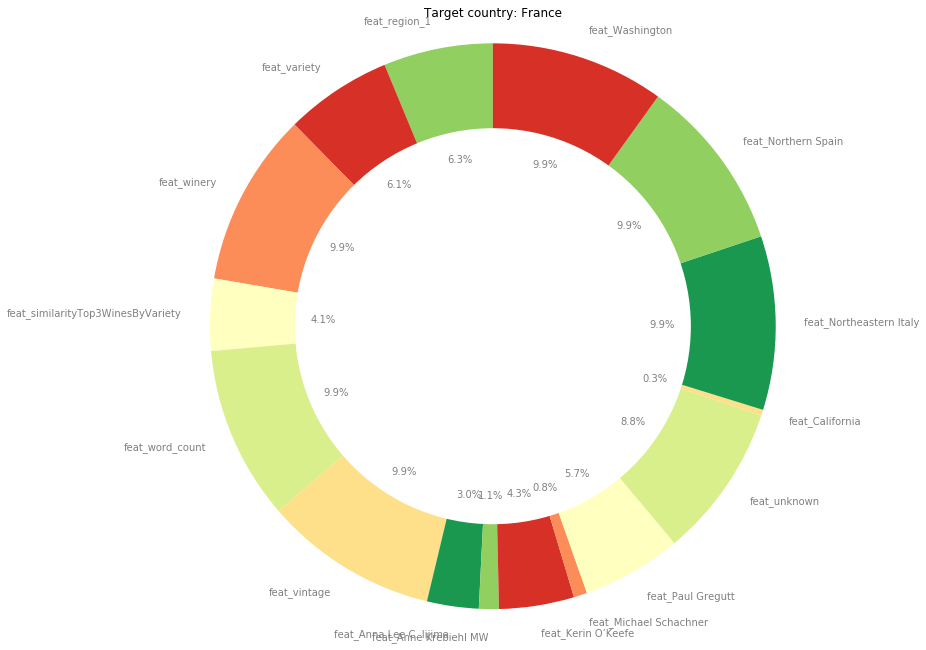

['feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown', 'feat_California', 'feat_Österreichischer Sekt']
[0.03745750950255533, 0.5377942389006829, 0.22670541073334916, 0.017255357146568274, 0.22688180538615718, 0.14848646819418676, 0.18173327634601602, 0.9635432853460918, 0.8265782563642903, 0.7506589811479626, 0.007765218066261833, 0.49684561447237335]


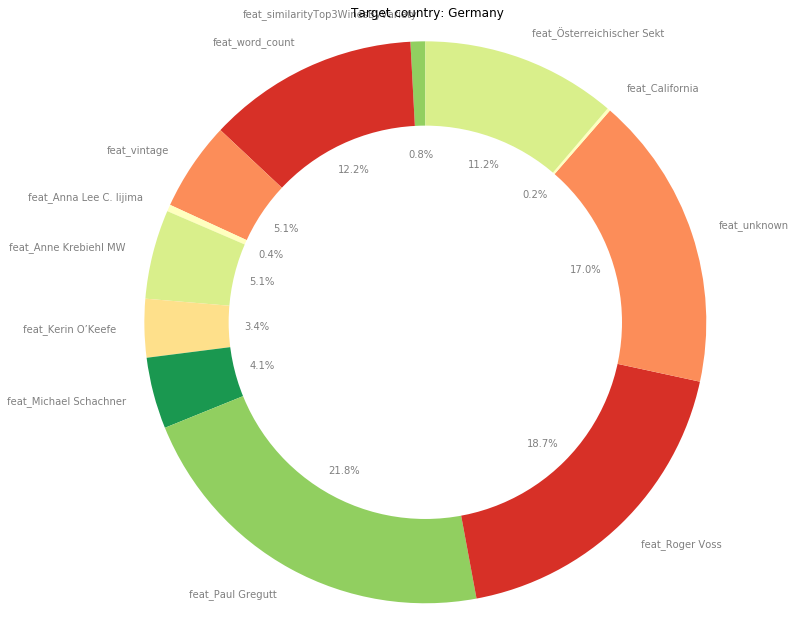

['feat_variety', 'feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown', 'feat_California', 'feat_New York', 'feat_Washington', 'feat_Österreichischer Sekt']
[0.9999999999999999, 0.9404991460129164, 0.27692213274600186, 0.5159026735241079, 0.649303243618226, 1.0, 0.26882133963078536, 0.16091667014595779, 1.0, 0.5282080310353439, 0.15729544025163236, 0.8366508661189318, 1.0, 0.9999999999999999, 0.8671094911794376, 1.0]


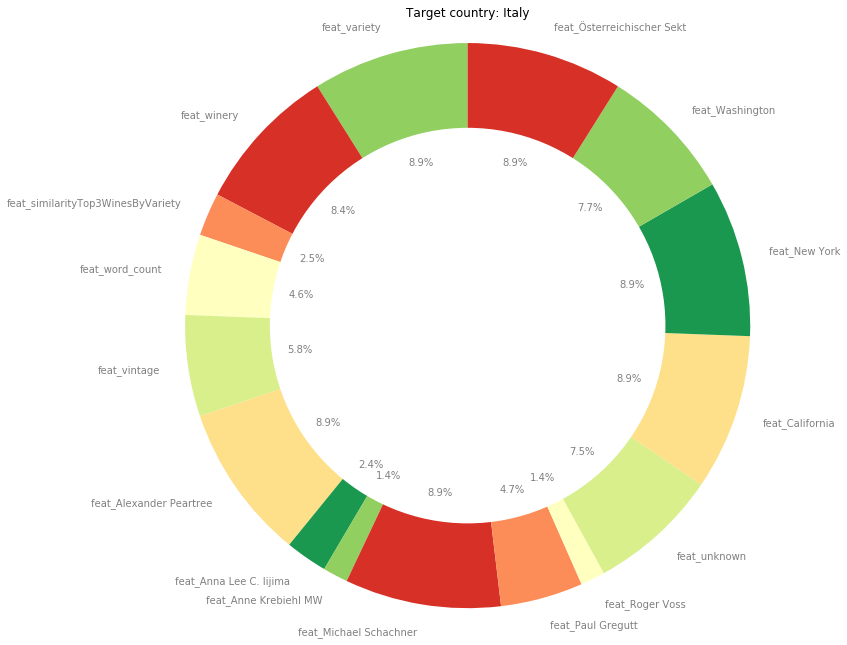

['feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown', 'feat_California', 'feat_New York', 'feat_Washington', 'feat_Österreichischer Sekt']
[0.8469175079635133, 0.08677858719757875, 0.5106821802404682, 0.3179901222488269, 0.2527839890808949, 0.07866198094515933, 0.17523911163279585, 0.4803472852011583, 0.49425760016575365, 0.8906227181647057, 0.9396416280816299, 0.007801243527620378, 0.8783369062091305, 0.8278514120648751, 0.49005578803476435]


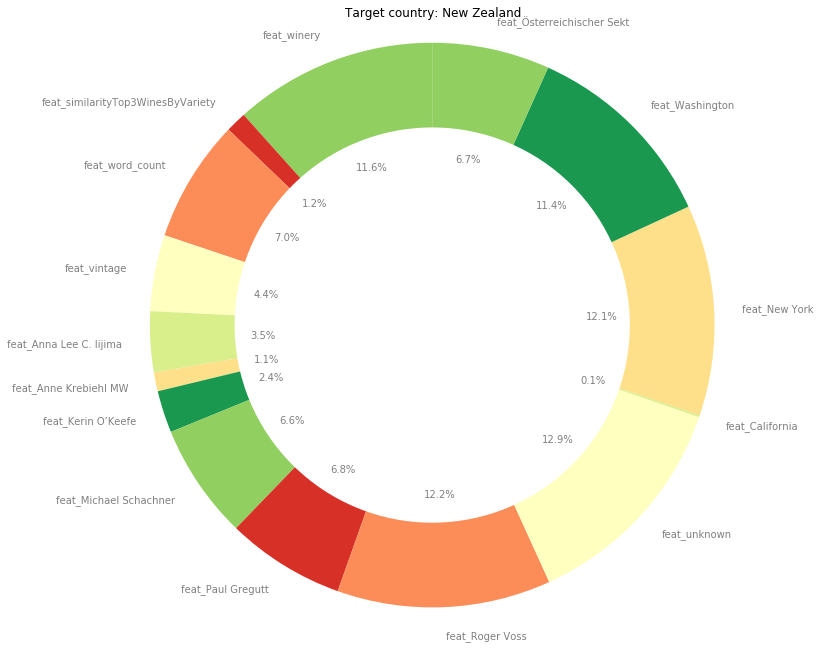

['feat_region_1', 'feat_word_count', 'feat_vintage', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown', 'feat_California', 'feat_Südsteiermark', 'feat_Österreichischer Sekt']
[0.008063105302239072, 0.788820548138075, 0.05978602998823336, 0.34640701407892077, 0.285301103667384, 0.18796824903010584, 0.31283372242913704, 1.0, 0.685803800896354, 0.7630654511709539, 0.04177389769225628, 1.0, 0.8132056222753304]


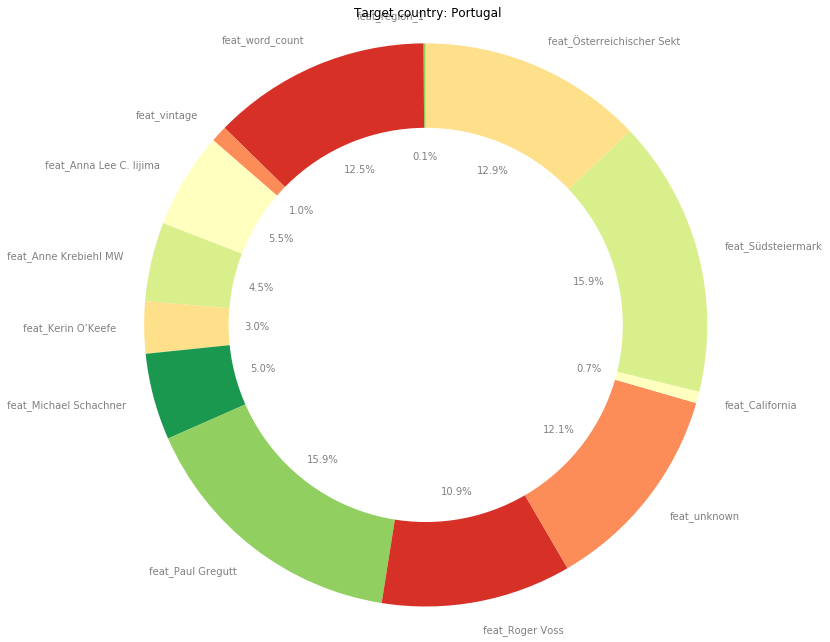

['feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown', 'feat_California', 'feat_Washington', 'feat_Österreichischer Sekt']
[0.8428075707720042, 0.10097339692496293, 0.5082584965313559, 0.2646742327947555, 0.2534072999639605, 0.07833897493376651, 0.2703808207035507, 0.5093613770673803, 0.4994147404949326, 0.9611881994197591, 0.9195867181707975, 0.05957347235659979, 0.7990630395646291, 0.4930541500711154]


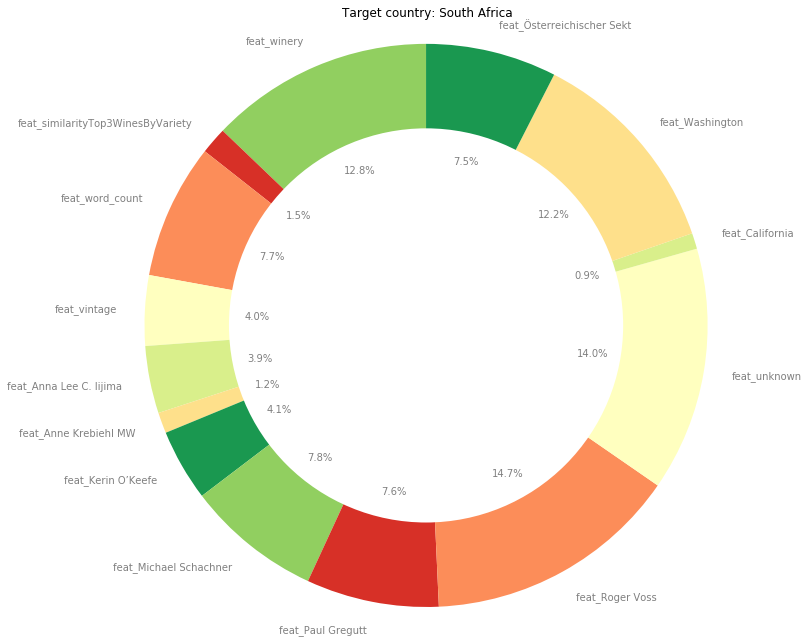

['feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_unknown', 'feat_California', 'feat_New York', 'feat_Österreichischer Sekt']
[0.14072305759032433, 0.5432316822184928, 0.272149827689724, 0.4219906578288804, 0.09185843533835279, 0.2893190560119907, 0.5226870968066024, 0.4532343087266503, 1.0, 0.9999999999999999, 0.06453855916438783, 0.9244183986313713, 0.5137511924805538]


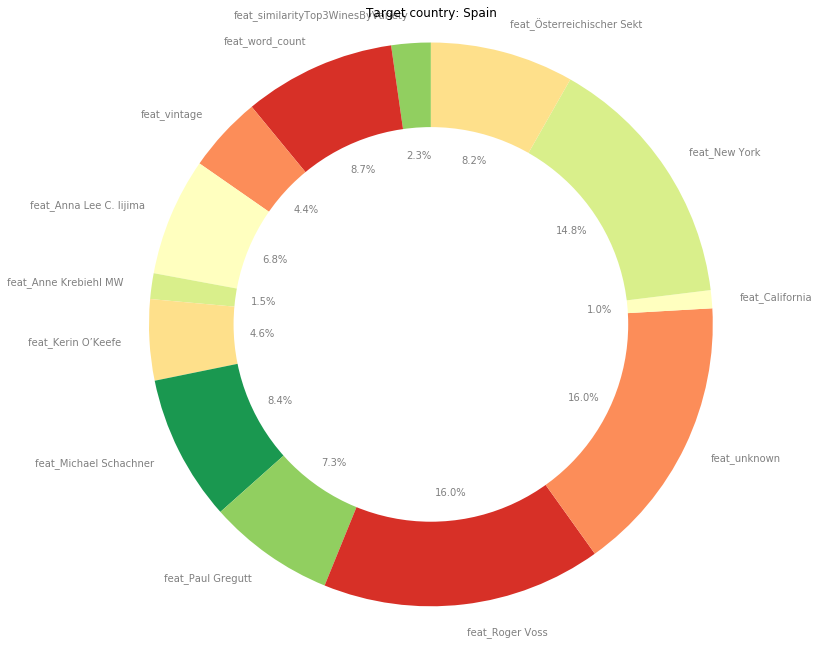

['feat_region_1', 'feat_variety', 'feat_similarityTop3WinesByVariety', 'feat_Anna Lee C. Iijima', 'feat_Anne Krebiehl\xa0MW', 'feat_Joe Czerwinski', 'feat_Kerin O’Keefe', 'feat_Michael Schachner', 'feat_Austria', 'feat_Baden', 'feat_Kamptal']
[0.16932428247783665, 0.5191734785102786, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 0.283865518166963, 1.0, 1.0, 1.0]


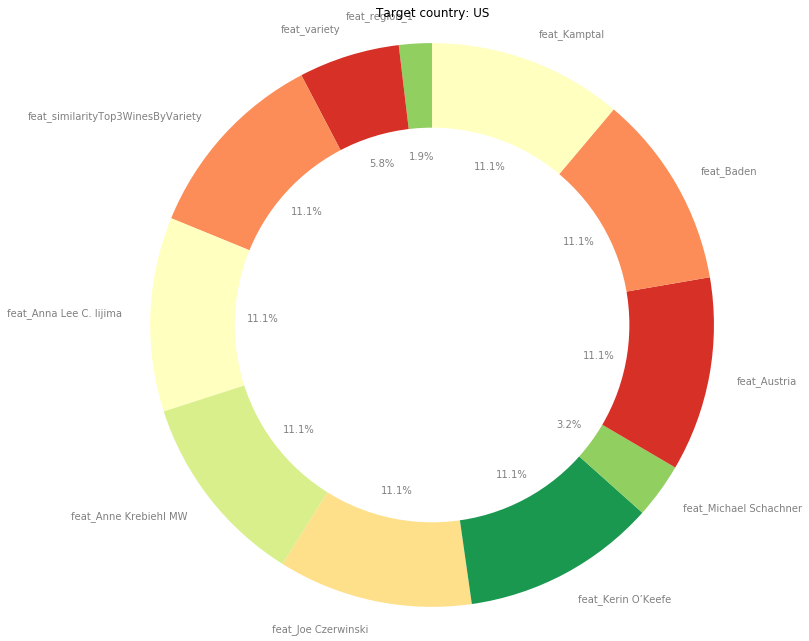

In [15]:
from sklearn import preprocessing

t2 = t1.drop(["ObjectiveCountry"],axis=1)
x = t2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
t3 = pd.DataFrame(x_scaled,columns=t2.columns)



import matplotlib.pyplot as plt

for idx,row in t3.iterrows():
    toPlot = []
    values = []
    for col in t3.columns:  
        if row[col] != 0 and col != "ObjectiveCountry" and col != "feat_price":    #ignore price
            toPlot.append(col)
            values.append(row[col])
    print(toPlot)
    print(values)

    fig, ax = plt.subplots(figsize = (9, 9))
    # create data
    names= toPlot  
    size= values
    colors =['#91cf60','#d73027','#fc8d59','#ffffbf','#d9ef8b','#fee08b','#1a9850']
    # Create a circle for the center of the plot
    my_circle=plt.Circle((0,0), 0.70, fc='white')
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    patches, texts, autotexts = ax.pie(size, labels=names, autopct='%1.1f%%', startangle=90,colors=colors)
    for text in texts:
        text.set_color('grey')
    for autotext in autotexts:
        autotext.set_color('grey')
    
    ax.axis('equal')  

    plt.tight_layout()
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

[['feat_California', 0.06090383181904845], ['feat_vintage', 0.08177710773742607], ['feat_similarityTop3WinesByVariety', 0.09767680931395678], ['feat_Anne Krebiehl\xa0MW', 0.14845875605033798], ['feat_Kerin O’Keefe', 0.24430621612729933], ['feat_Anna Lee C. Iijima', 0.25771821244836857], ['feat_Österreichischer Sekt', 0.4561525975880225], ['feat_Paul Gregutt', 0.5005448591856141], ['feat_word_count', 0.541386771468829], ['feat_Washington', 0.8106340735356595], ['feat_winery', 0.8797548977283339], ['feat_New York', 0.9116169579763092], ['feat_Roger Voss', 0.9498168473702502], ['feat_unknown', 0.958576480127003]]


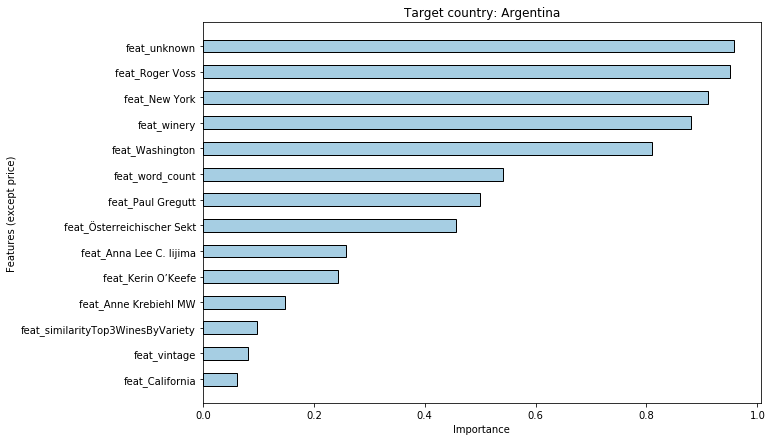

[['feat_California', 0.007036711100141844], ['feat_similarityTop3WinesByVariety', 0.07929666847445416], ['feat_Anne Krebiehl\xa0MW', 0.14114299386286694], ['feat_Michael Schachner', 0.1825526740746673], ['feat_Kerin O’Keefe', 0.19075006563895797], ['feat_Anna Lee C. Iijima', 0.2572264728604512], ['feat_vintage', 0.4330267483026902], ['feat_Österreichischer Sekt', 0.4975858769597316], ['feat_Paul Gregutt', 0.5063927747265016], ['feat_word_count', 0.5123358963491231], ['feat_Washington', 0.8111775742673301], ['feat_winery', 0.8505539283066603], ['feat_New York', 0.8943753244766887], ['feat_unknown', 0.8975582663184156], ['feat_Roger Voss', 0.9138151867107667]]


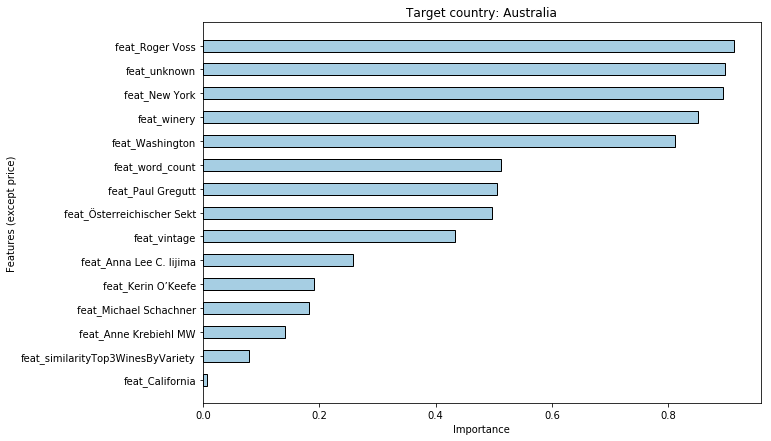

[['feat_California', 0.007836798725396398], ['feat_similarityTop3WinesByVariety', 0.12431118953164622], ['feat_Kerin O’Keefe', 0.14645555030810264], ['feat_vintage', 0.24854283415890854], ['feat_Anna Lee C. Iijima', 0.2634436080744587], ['feat_Michael Schachner', 0.32177289016959815], ['feat_Paul Gregutt', 0.5121444950150678], ['feat_word_count', 0.5334527896658803], ['feat_unknown', 0.7383209391146347], ['feat_Roger Voss', 0.8347877364471737], ['feat_winery', 0.8612769027859559], ['feat_Washington', 0.8632137802622089], ['feat_New York', 0.8893405728747442]]


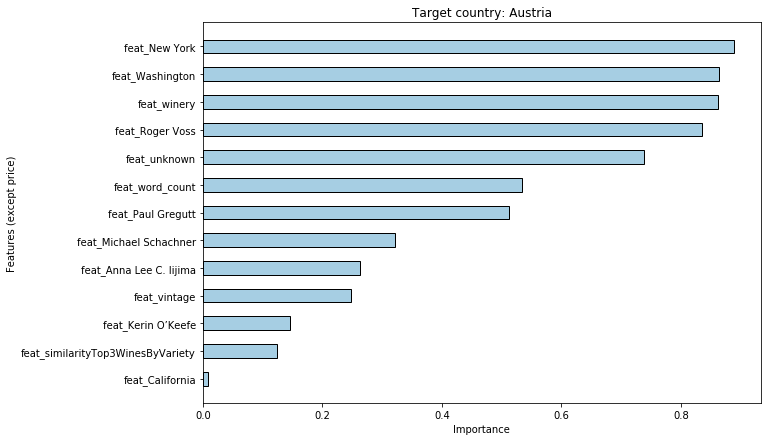

[['feat_California', 0.007493178914374366], ['feat_similarityTop3WinesByVariety', 0.059154423942290535], ['feat_Anne Krebiehl\xa0MW', 0.0825589313558545], ['feat_Paul Gregutt', 0.18522950927631454], ['feat_Kerin O’Keefe', 0.20035549343204975], ['feat_vintage', 0.3332041364867091], ['feat_Washington', 0.3502561904549731], ['feat_Österreichischer Sekt', 0.5145813065789555], ['feat_word_count', 0.5772036018291642], ['feat_New York', 0.921336342559472], ['feat_Roger Voss', 0.9283960321239266], ['feat_Alexander Peartree', 0.9314148348564248], ['feat_unknown', 0.98801976797908], ['feat_region_1', 1.0], ['feat_Jim Gordon', 1.0], ['feat_Lauren Buzzeo', 1.0]]


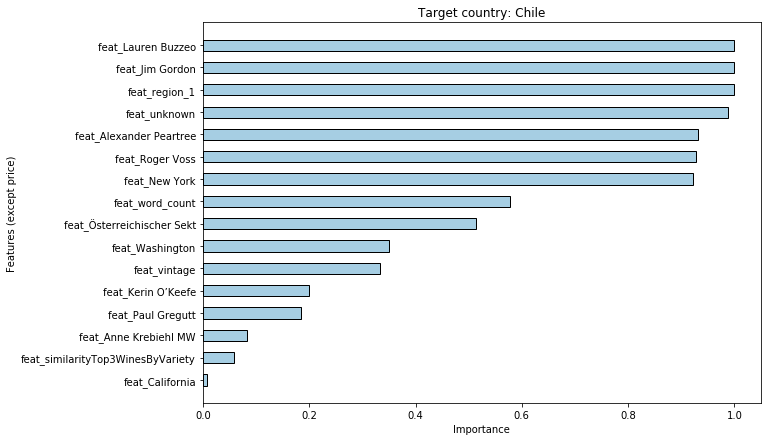

[['feat_California', 0.033830066537312686], ['feat_Michael Schachner', 0.07715770010033497], ['feat_Anne Krebiehl\xa0MW', 0.1144814283804605], ['feat_Anna Lee C. Iijima', 0.2975517982537584], ['feat_similarityTop3WinesByVariety', 0.413836749529238], ['feat_Kerin O’Keefe', 0.43162757346089686], ['feat_Paul Gregutt', 0.5739644827210987], ['feat_variety', 0.6162972890283231], ['feat_region_1', 0.6298900187589057], ['feat_unknown', 0.8858201076552557], ['feat_winery', 0.9999999999999999], ['feat_word_count', 1.0], ['feat_vintage', 1.0], ['feat_Northeastern Italy', 1.0], ['feat_Northern Spain', 1.0], ['feat_Washington', 1.0]]


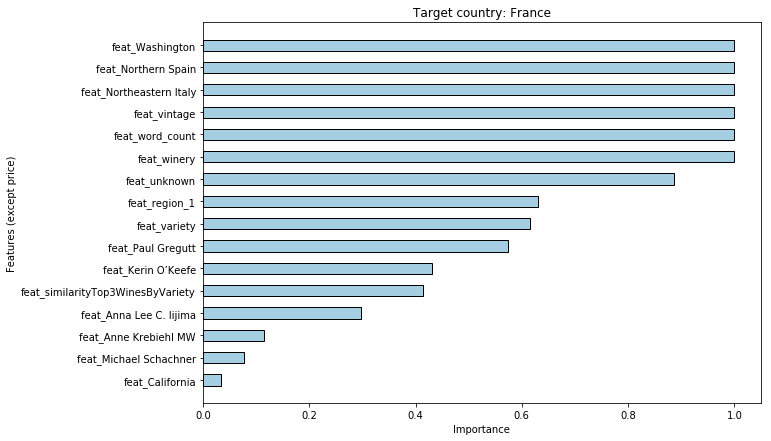

[['feat_California', 0.007765218066261833], ['feat_Anna Lee C. Iijima', 0.017255357146568274], ['feat_similarityTop3WinesByVariety', 0.03745750950255533], ['feat_Kerin O’Keefe', 0.14848646819418676], ['feat_Michael Schachner', 0.18173327634601602], ['feat_vintage', 0.22670541073334916], ['feat_Anne Krebiehl\xa0MW', 0.22688180538615718], ['feat_Österreichischer Sekt', 0.49684561447237335], ['feat_word_count', 0.5377942389006829], ['feat_unknown', 0.7506589811479626], ['feat_Roger Voss', 0.8265782563642903], ['feat_Paul Gregutt', 0.9635432853460918]]


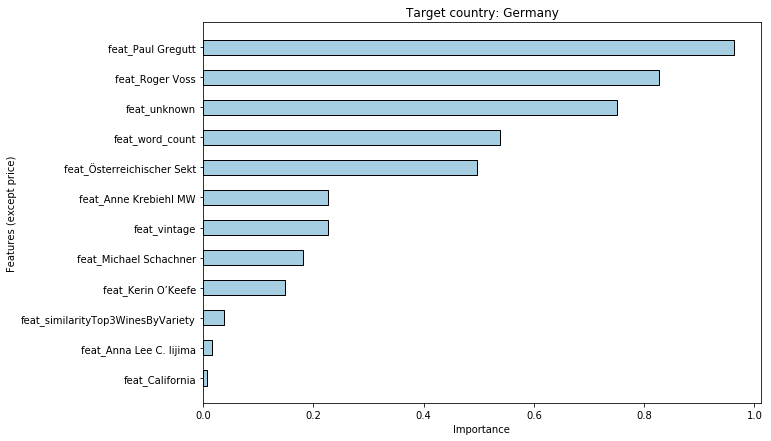

[['feat_Roger Voss', 0.15729544025163236], ['feat_Anne Krebiehl\xa0MW', 0.16091667014595779], ['feat_Anna Lee C. Iijima', 0.26882133963078536], ['feat_similarityTop3WinesByVariety', 0.27692213274600186], ['feat_word_count', 0.5159026735241079], ['feat_Paul Gregutt', 0.5282080310353439], ['feat_vintage', 0.649303243618226], ['feat_unknown', 0.8366508661189318], ['feat_Washington', 0.8671094911794376], ['feat_winery', 0.9404991460129164], ['feat_variety', 0.9999999999999999], ['feat_New York', 0.9999999999999999], ['feat_Alexander Peartree', 1.0], ['feat_Michael Schachner', 1.0], ['feat_California', 1.0], ['feat_Österreichischer Sekt', 1.0]]


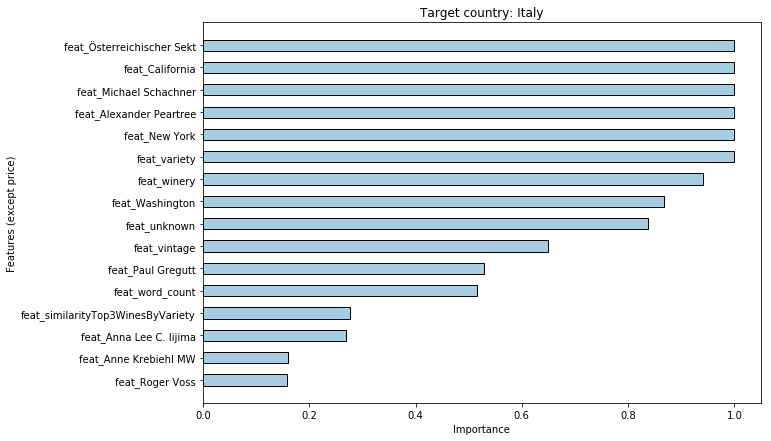

[['feat_California', 0.007801243527620378], ['feat_Anne Krebiehl\xa0MW', 0.07866198094515933], ['feat_similarityTop3WinesByVariety', 0.08677858719757875], ['feat_Kerin O’Keefe', 0.17523911163279585], ['feat_Anna Lee C. Iijima', 0.2527839890808949], ['feat_vintage', 0.3179901222488269], ['feat_Michael Schachner', 0.4803472852011583], ['feat_Österreichischer Sekt', 0.49005578803476435], ['feat_Paul Gregutt', 0.49425760016575365], ['feat_word_count', 0.5106821802404682], ['feat_Washington', 0.8278514120648751], ['feat_winery', 0.8469175079635133], ['feat_New York', 0.8783369062091305], ['feat_Roger Voss', 0.8906227181647057], ['feat_unknown', 0.9396416280816299]]


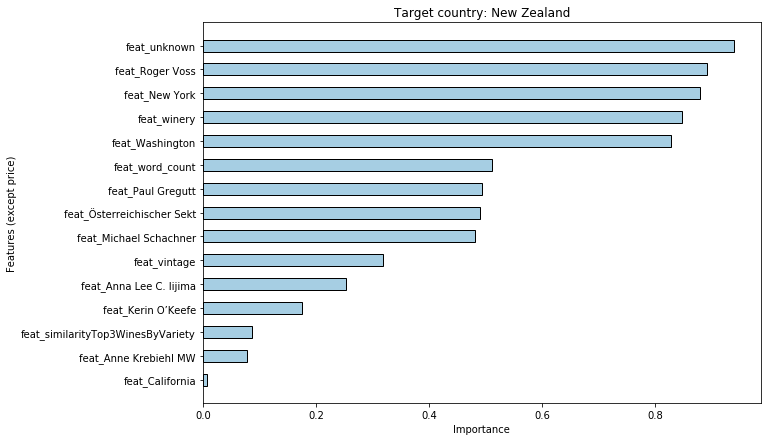

[['feat_region_1', 0.008063105302239072], ['feat_California', 0.04177389769225628], ['feat_vintage', 0.05978602998823336], ['feat_Kerin O’Keefe', 0.18796824903010584], ['feat_Anne Krebiehl\xa0MW', 0.285301103667384], ['feat_Michael Schachner', 0.31283372242913704], ['feat_Anna Lee C. Iijima', 0.34640701407892077], ['feat_Roger Voss', 0.685803800896354], ['feat_unknown', 0.7630654511709539], ['feat_word_count', 0.788820548138075], ['feat_Österreichischer Sekt', 0.8132056222753304], ['feat_Paul Gregutt', 1.0], ['feat_Südsteiermark', 1.0]]


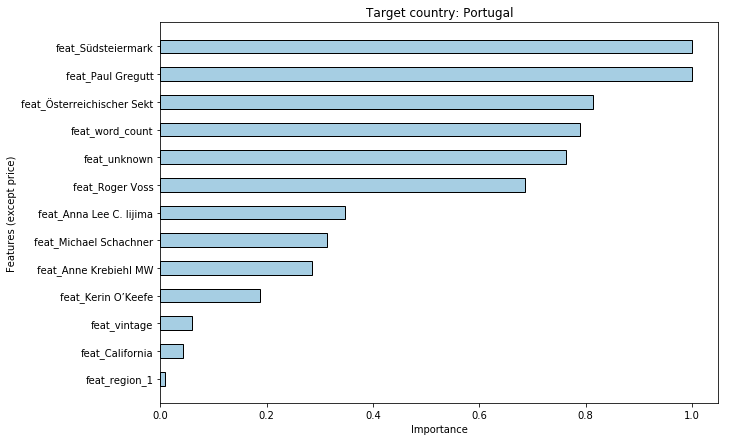

[['feat_California', 0.05957347235659979], ['feat_Anne Krebiehl\xa0MW', 0.07833897493376651], ['feat_similarityTop3WinesByVariety', 0.10097339692496293], ['feat_Anna Lee C. Iijima', 0.2534072999639605], ['feat_vintage', 0.2646742327947555], ['feat_Kerin O’Keefe', 0.2703808207035507], ['feat_Österreichischer Sekt', 0.4930541500711154], ['feat_Paul Gregutt', 0.4994147404949326], ['feat_word_count', 0.5082584965313559], ['feat_Michael Schachner', 0.5093613770673803], ['feat_Washington', 0.7990630395646291], ['feat_winery', 0.8428075707720042], ['feat_unknown', 0.9195867181707975], ['feat_Roger Voss', 0.9611881994197591]]


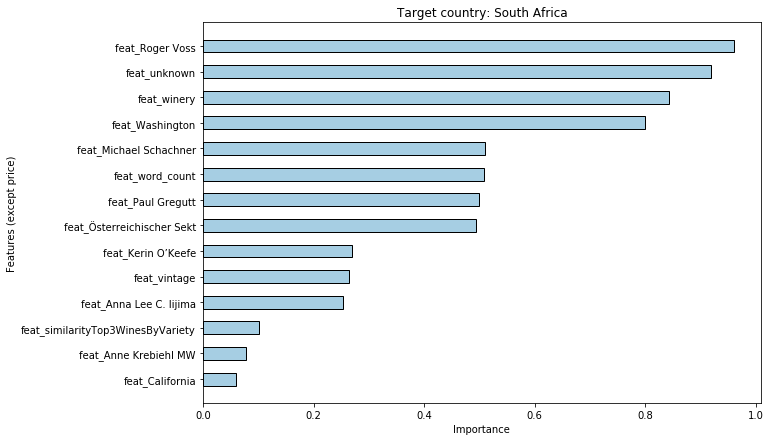

[['feat_California', 0.06453855916438783], ['feat_Anne Krebiehl\xa0MW', 0.09185843533835279], ['feat_similarityTop3WinesByVariety', 0.14072305759032433], ['feat_vintage', 0.272149827689724], ['feat_Kerin O’Keefe', 0.2893190560119907], ['feat_Anna Lee C. Iijima', 0.4219906578288804], ['feat_Paul Gregutt', 0.4532343087266503], ['feat_Österreichischer Sekt', 0.5137511924805538], ['feat_Michael Schachner', 0.5226870968066024], ['feat_word_count', 0.5432316822184928], ['feat_New York', 0.9244183986313713], ['feat_unknown', 0.9999999999999999], ['feat_Roger Voss', 1.0]]


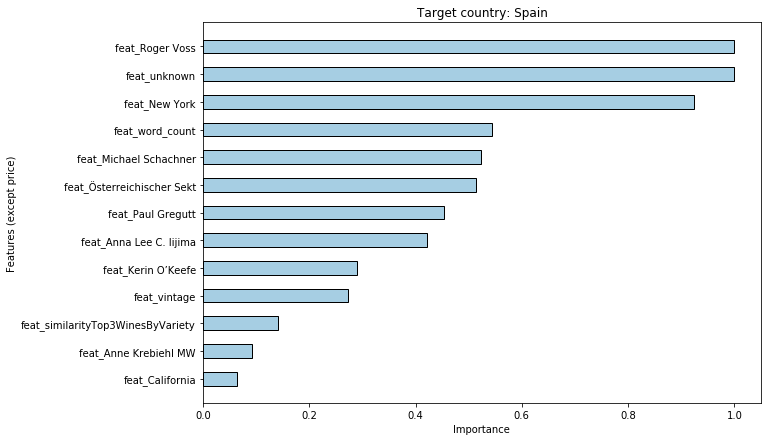

[['feat_region_1', 0.16932428247783665], ['feat_Michael Schachner', 0.283865518166963], ['feat_variety', 0.5191734785102786], ['feat_Kerin O’Keefe', 0.9999999999999999], ['feat_similarityTop3WinesByVariety', 1.0], ['feat_Anna Lee C. Iijima', 1.0], ['feat_Anne Krebiehl\xa0MW', 1.0], ['feat_Joe Czerwinski', 1.0], ['feat_Austria', 1.0], ['feat_Baden', 1.0], ['feat_Kamptal', 1.0]]


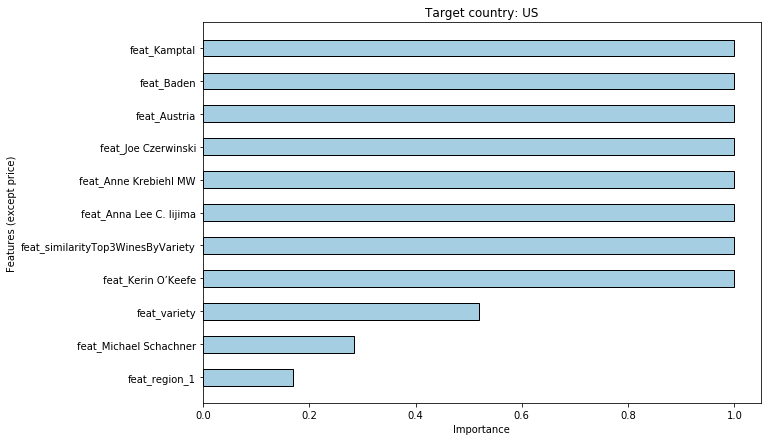

In [16]:
for idx,row in t3.iterrows():
    both = []
    for col in t3.columns:
        if row[col] != 0 and col != "ObjectiveCountry" and col != "feat_price":    #ignore price
            both.append([col,row[col]])
    #print(toPlot)
    #print(values)
    
    from operator import itemgetter
    both = sorted(both, key=itemgetter(1))
    print(both)
    
    toPlot = []
    values = []    
    for el in both:
        toPlot.append(el[0])
        values.append(el[1])
    
    # width of the bars
    barWidth = 0.5
    
    # Choose the height of the blue bars
    bars1 = values

    # The x position of bars
    r1 = np.arange(len(toPlot))
    fig, ax = plt.subplots(figsize = (10, 7))

    # Create blue bars
    plt.barh(r1, bars1, height=barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7)
    #plt.bar(r1,bars1,width = barWidth..)
    ys = toPlot
    # general layout
    #plt.xticks([r for r in range(len(bars1))], ys,rotation='vertical')
    #plt.yticks([r for r in range(len(bars1))], ys,rotation='vertical')
    plt.yticks([r for r in range(len(bars1))], ys)
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    plt.ylabel('Features (except price)')
    plt.xlabel("Importance")
    # Show graphic
    plt.show()

# radar chart to compare importances between regression and dectrees?

In [ ]:
#"algorithm" feaeture must be in the dataset here

df1 = result.head(4)
test = result.iloc[5]
feats = []
values = []

genFeatures = []
for col in result.columns:
    if(col.startswith("feat_")):
            genFeatures.append(col)
print(genFeatures)

for col in result.columns:
    if(col.startswith("feat_")) and (test[col] != 100):
        print(col,test[col])
        feats.append(col)
        values.append(test[col])
df1

In [ ]:
#per il radar chart, va bene probabilmente solo per la comparazione dei risultati delle importanze per linear regression e dectreeclass

#oppure anche per i risultati di precision recall e f1 score?

df = pd.DataFrame()
df = df1[["algorithm"] + genFeatures]
df = df.reset_index(drop=True)
#df.drop(["algorithm"],axis=1,inplace=True)
for col in df.columns:
    df[col] = df[col].replace(100,0)
    if len(df[col].unique().tolist()) == 1 and col != "algorithm":
        df.drop(col,inplace=True,axis=1)
df

In [ ]:
#devi costruire il dataframe 

In [ ]:
def make_spider(row, title):#,# color):
 
    # number of variable
    categories=list(df)[1:]
    #print(categories)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,2,idx+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.1,0.25,0.50,1], ["0.1","0.25","50","1"], color="grey", size=7)
    plt.ylim(0,1)

    # Ind1
    values=df.loc[idx].drop("algorithm").values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1)
    ax.fill(angles, values, alpha=0.4)

    # Add a title
    plt.title(title, size=11, y=1.1)
    
# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
#my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for idx,row in df.iterrows():
    make_spider(row,"culo") #,my_palette(row))

In [ ]:
df = df[df["feat_winery"] != 0]
df = df.reset_index(drop=True)
print(df)
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('algorithm').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.1,0.25,0.50,1], ["0.1","0.25","0.50","1"], color="grey", size=7)
plt.ylim(0,1)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)



# CLASSIFIER WITHOUT SPARSE MATRIX

In [ ]:
def decTree(features, depth, data,Y):
    X = data.loc[:,features]
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    y_train = list(y_train)
    classifier = DecisionTreeClassifier(max_depth=depth)
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)  
    acc = accuracy_score(y_test,y_pred)
    weightedPrec = precision_score(y_test,y_pred,average="weighted")
    print(acc,weightedPrec)
    #get feature importances
    lista = []
    for name, importance in zip(features, classifier.feature_importances_):
        lista.append([name, importance])
    precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred,labels=labels)
    print(classification_report(y_test, y_pred, target_names=labels))
    return classifier

In [ ]:
temp = pd.DataFrame()
temp = wine_base
Y = temp['points'].copy()
nbins  = 3
labels=["low","medium","high"]
Y,bins = pd.qcut(Y,nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
temp = temp.drop(["points","country"],axis=1)
temp

In [ ]:
features = temp.columns
depth = 4
clf = decTree(features,depth,temp,Y)

In [ ]:
#show me the tree

##### Graphviz sucks, you need to check if it's installed and it may give you problems anyway, the code below fixed it for me"
#### be sure that you have the package installed
import os
import sys
def conda_fix(graph):
        path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
        paths = ("dot", "twopi", "neato", "circo", "fdp")
        paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
        graph.set_graphviz_executables(paths)
import pydotplus 
from sklearn import tree
from IPython.display import Image  
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features,  
                         class_names=labels,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
conda_fix(graph)
Image(graph.create_png())

# Test with combinations and get results dataframe (no countvect working on this as of now)

In [ ]:
#create a dataframe with every test combination you put
def testToDataFrame(algorithm,combination,Y,allfeats,dataset):
    test_size = 0.30 
    cols = ["algorithm","input","precision","accuracy","depth"]
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in allfeats: #controlla che allfeats vada bene, amgari fotte con l'ordine
        cols.append("feat_"+el)
    results = pd.DataFrame()
    row = 0
    comb = 0
    for el in combination["args"]: 
        for depth in combination["depth"]:
            row = row + 1
            X = dataset.loc[:,el]
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
            if algorithm == "decTree":
                classifier = DecisionTreeClassifier(max_depth=depth)
            else:
                classifier = RandomForestClassifier(max_depth=depth,n_estimators = estimators)
            classifier.fit(X_train,y_train)
            y_pred = classifier.predict(X_test)  
            acc = accuracy_score(y_test,y_pred)
            weightedPrec = precision_score(y_test,y_pred,average="weighted")        
            data = [algorithm,el,weightedPrec,acc,depth]
            precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
            for i in range(0,len(labels)):
                data.append(precision[i])
                data.append(recall[i])
                data.append(fscore[i])
                data.append(support[i])
            #for lab in labels:
            
             #   data.append(rep[lab].precision)     #ORDER IS VERY IMPORTANT
              #  data.append(rep[lab].recall)
               # data.append(rep[lab].f1-score)
                #data.append(rep[lab].support)
            temp = {}
            c = zip(el,classifier.feature_importances_)
            counter = 0
            for name,importance in c:
                if importance > 0:
                    temp[name] = importance
                    counter += 1
            data.append(counter)
            for feat in allfeats:
                if feat not in el:
                    data.append(100) #100 is an impossible value not to be taken into account
                else:
                    data.append(temp[feat])
            df2 = pd.DataFrame([data],columns=cols)
            results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [ ]:
args = [["price"],["price","word_count"],basic,basic+tfGroup, basic+word2vec,basic+word2vec+tfGroup,word2vec,tfGroup,word2vec+tfGroup]
allfeatures = basic + word + word2vec + tfGroup 
decTreeCombinations = {"depth":[2,3,4,5],"args":args}

In [ ]:
res = testToDataFrame("decTree",decTreeCombinations,Y,allfeatures,wine_base)

In [ ]:
res.sort_values(["precision",'depth'],ascending=False)

In [ ]:
res.iloc[19]

In [ ]:
res.iloc[17]

# Classifier using sparse matrix, don't know why gives errors of type

wine_base = pd.read_csv("Our_dataset/StemmedWord2vecTop3_parsed.csv", index_col=0) 
wine_base = wine_base.reset_index()
wine_base= wine_base[pd.notnull(wine_base['description'])]


for col in wine_base.columns:
    if(col.startswith("tf")):
            wine_base.drop(col,inplace=True,axis=1)

import re
def get_vintage(df):
    pattern = r"\d{4}"
    vintages = []
    for elem in df.title:
        match = re.findall(pattern,elem)
        year = 0
        if len(match)>1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif y == 7200:
                year = int(match[1])
            else:
                year= y
        elif len(match)==1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif year == 7200:
                year = 0
            else:
                year = y
        else:
            year = 0
        vintages.append(year)

    se = pd.Series(vintages)
    df['vintage']=se.values 
    df.drop('title',axis=1)
    return df

wine_base = get_vintage(wine_base)
#drop reviwe of wine with ventage =0
wine_base = wine_base[wine_base.vintage != 0]

wine_base = wine_base[pd.notnull(wine_base['country'])]
wine_base = wine_base[pd.notnull(wine_base['taster_name'])]
wine_base = wine_base[pd.notnull(wine_base["variety"])]
wine_base = wine_base[pd.notnull(wine_base["province"])]
wine_base = wine_base[pd.notnull(wine_base["winery"])]

wine_base.drop("title",inplace=True,axis=1)
wine_base = wine_base.dropna()

#keep track of the countries,provinces,taster_names in the database
countries = wine_base["country"].unique().tolist()
provinces = wine_base["province"].unique().tolist()
tasters = wine_base["taster_name"].unique().tolist()

def OneHotEncode(dataframe,column_to_encode,take_whole_dataset=True):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(dataframe[[column_to_encode]])
    mapping = {}
    i=0
    for elem in enc.categories_[0]:
        mapping[elem]=i
        i+=1
    resu = enc.transform(dataframe[[column_to_encode]]).toarray()
    if take_whole_dataset:
        for elem in mapping:
            dataframe[elem]=resu[:,mapping[elem]]
        return dataframe
    else:
        subset = dataframe[[column_to_encode]]
        for elem in mapping:
            subset[elem]=resu[:,mapping[elem]]
        return subset

wine_base = OneHotEncode(wine_base,'taster_name')
wine_base = wine_base.drop('taster_name', 1)
wine_base = OneHotEncode(wine_base,'province')
wine_base = wine_base.drop('province', 1)


wine_base.drop(["designation"],axis=1,inplace=True)


lb = LabelBinarizer()

wine_base["winery"] = wine_base["winery"].astype('category').cat.codes
wine_base["region_1"] = wine_base["region_1"].astype('category').cat.codes
wine_base["variety"] = wine_base["variety"].astype('category').cat.codes


def sparseMatrixRep(features,depth,data,test_size):
    X = data.loc[:,features]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    #compute countvectorizer
    
    vect = CountVectorizer(min_df=5)
    t = vect.fit_transform(X_train["description"])
    vect.fit(X_train['description'])
    print("vocabulary size: {}".format(len(vect.vocabulary_)))
    X_train_vectored_cv = vect.transform(X_train['description'])
    X_train_final = X_train_vectored_cv
    for feature in features:
        X_train_final = hstack((X_train_final,np.array(X_train[feature])[:,None]))
    
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train_final, y_train)
    
    y_train_pred = clf.predict(X_train_final)
    X_test_final = vect.transform(X_test['description'])
    for feature in features:
        X_test_final = hstack((X_test_final,np.array(X_test[feature])[:,None]))

    y_test_pred = clf.predict(X_test_final)
    print(classification_report(y_test, y_test_pred, target_names=labels))
    
    return clf

#doesn't work dunno why
#change the input and compute

depth = 3
test_size = 0.30
tem = pd.DataFrame()
tem = wine_base.drop("points",axis=1)
features = ["price","description"]
clf = sparseMatrixRep(features,depth,tem,test_size)

#show me the tree
##### Graphviz sucks, you need to check if it's installed and it may give you problems anyway, the code below fixed it for me"
#### be sure that you have the package installed

import os
import sys
import pydotplus 
from sklearn import tree
from IPython.display import Image  

def conda_fix(graph):
    path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
    paths = ("dot", "twopi", "neato", "circo", "fdp")
    paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
    graph.set_graphviz_executables(paths)
    
dot_data = tree.export_graphviz(clf, out_file=None,   
                             class_names=labels,  
                             filled=True, rounded=True,  
                             special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
conda_fix(graph)
Image(graph.create_png())

# TRAIN ON ONE COUNTRY, TEST ON THE OTHERS

In [ ]:
#wine_base["country_tag"] = wine_base["country"].astype('category').cat.codes
#wine_base.drop("region_1",inplace=True,axis=1)

#this way, the only missing attribute is the country, so that the classifier doesn't work on which country it comes from

In [27]:
def trainByCountry(data,countries):
    #for every country, use it as test set
    nbins  = 3
    labels=["low","medium","high"]
    wine2 = pd.DataFrame()
    wine2 = data
    g,b = pd.qcut(data["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
    g.tolist()
    wine3 = wine2.drop(["points"],axis=1)
    wine3["category"] = g
    df = pd.DataFrame()
    for el in countries:
        res = applyTest1(wine3,el)
        df = df.append(res)
    return df

def applyTest1(data,objCountry):
  
    #set many different combinations
    #only on these
    allfeatures = []
    args = []
    for el in wine_base.columns:
        if el != "description":
            allfeatures.append(el)   
        if el != "description" and el != "points" and el != "country":
            args.append(el)
    combos = {"depth":[2,3,4,5,6],"args":[args]}
    #
    res = buildCountryResult1(data,args,allfeatures,combos,objCountry)
    return res

def buildCountryResult1(data,args,allfeatures,combination,objCountry):
    cols = ["algorithm","ObjectiveCountry","input","precision","accuracy","f1","depth"]
    algorithm = "decTree"
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in args: #controlla che allfeats vada bene
        c = "feat_"+el
        if c not in cols:
            cols.append(c)
    results = pd.DataFrame()
    comb = 0
    row = 0
    for el in combination["args"]: 
        el = el + ["country","category"]
        X = data[el]
        #create test and training sets
        X_train = X[X["country"] == objCountry]
        y_train = pd.DataFrame()
        y_train = list(X_train["category"])
        print(objCountry +" must be the only one in the training set " + str(X_train["country"].unique().tolist()))
        print(str(X_train["country"].unique().tolist()) + "country in the training set")
        X_train.drop(["country","category"],axis=1,inplace=True)

        X_test = X[X["country"] != objCountry]
        y_test = X_test["category"]
        print(str(X_test["country"].unique().tolist()) + "country in the test set")
        X_test.drop(["country","category"],axis=1,inplace=True)
        for depth in combination["depth"]:
                row = row + 1  
                #train stuff
                classifier = DecisionTreeClassifier(max_depth=depth)
                classifier.fit(X_train,y_train)
                y_pred = classifier.predict(X_test)  
                acc = accuracy_score(y_test,y_pred)#average="macro")
                weightedPrec = precision_score(y_test,y_pred,average="weighted")
                f1 = f1_score(y_test,y_pred,average="weighted")
                rowData = [algorithm,objCountry,el,weightedPrec,acc,f1,depth]
                precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
                for i in range(0,len(labels)):
                    rowData.append(precision[i])
                    rowData.append(recall[i])
                    rowData.append(fscore[i])
                    rowData.append(support[i])
                    temp = {}
                c = zip(el,classifier.feature_importances_)
                names = []
                for name,importance in c:
                    temp[name] = importance
                    names.append(name)
                for feat in names:
                    #if feat not in allfeatures:
                     #   rowData.append(100) #100 is an impossible value not to be taken into account
                    #else:
                        rowData.append(temp[feat]) #qualcosa non quadra con le liste di input e colonne per appendere i dataframe con le relative feature importances
                df2 = pd.DataFrame([rowData],columns=cols)
                results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [28]:
trainedOnSingleCountry = trainByCountry(wine_base,countries)
trainedOnSingleCountry.drop("input",inplace=True,axis=1)
trainedOnSingleCountry

Italy must be the only one in the training set ['Italy']
['Italy']country in the training set
['Portugal', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']country in the test set
Portugal must be the only one in the training set ['Portugal']
['Portugal']country in the training set
['Italy', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']country in the test set
US must be the only one in the training set ['US']
['US']country in the training set
['Italy', 'Portugal', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']country in the test set
Spain must be the only one in the training set ['Spain']
['Spain']country in the training set
['Italy', 'Portugal', 'US', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']country in the test set
France must be the only one 

E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Argentina must be the only one in the training set ['Argentina']
['Argentina']country in the training set
['Italy', 'Portugal', 'US', 'Spain', 'France', 'Germany', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']country in the test set
Chile must be the only one in the training set ['Chile']
['Chile']country in the training set
['Italy', 'Portugal', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Australia', 'Austria', 'South Africa', 'New Zealand']country in the test set
Australia must be the only one in the training set ['Australia']
['Australia']country in the training set
['Italy', 'Portugal', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Austria', 'South Africa', 'New Zealand']country in the test set
Austria must be the only one in the training set ['Austria']
['Austria']country in the training set
['Italy', 'Portugal', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'South Africa', 'New Zealand']country in the test set


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


South Africa must be the only one in the training set ['South Africa']
['South Africa']country in the training set
['Italy', 'Portugal', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'New Zealand']country in the test set
New Zealand must be the only one in the training set ['New Zealand']
['New Zealand']country in the training set
['Italy', 'Portugal', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa']country in the test set


,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,low_support,...,feat_Washington-Oregon,feat_Weinland Österreich,feat_Weinviertel,feat_Wellington,feat_Western Australia,feat_Western Cape,feat_Wiener Gemischter Satz,feat_Württemberg,feat_Österreichischer Perlwein,feat_Österreichischer Sekt
0,decTree,Italy,0.530938,0.527166,0.516210,2,0.665851,0.417228,0.513003,26736,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,decTree,Italy,0.611220,0.521789,0.503096,3,0.819426,0.188061,0.305914,26736,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,decTree,Italy,0.551926,0.534755,0.526595,4,0.700737,0.384126,0.496231,26736,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,decTree,Italy,0.570695,0.571793,0.558036,5,0.700145,0.468544,0.561396,26736,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,decTree,Italy,0.572409,0.567029,0.555227,6,0.721893,0.455341,0.558440,26736,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0,decTree,Portugal,0.604446,0.531358,0.530190,2,0.572651,0.658055,0.612390,29496,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,decTree,Portugal,0.535104,0.541381,0.536823,3,0.572651,0.658055,0.612390,29496,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,decTree,Portugal,0.507995,0.521639,0.503186,4,0.498370,0.740948,0.595918,29496,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,decTree,Portugal,0.527248,0.543264,0.528767,5,0.566896,0.699722,0.626345,29496,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,decTree,Portugal,0.548747,0.526346,0.520446,6,0.500625,0.787395,0.612086,29496,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [19]:
#if the column is never used delete it
for col in trainedOnSingleCountry.columns:
    if len(trainedOnSingleCountry[col].unique().tolist()) == 1 and col != "algorithm":
        trainedOnSingleCountry.drop(col,inplace=True,axis=1)
len(trainedOnSingleCountry.columns)

79

In [20]:
trainedOnSingleCountry

,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,low_support,...,feat_Südsteiermark,feat_Tasmania,feat_Tejo,feat_Traisental,feat_Trás-os-Montes,feat_Tuscany,feat_Virginia,feat_Waipara,feat_Weinviertel,feat_Österreichischer Sekt
0,decTree,Italy,0.530938,0.527166,0.516210,2,0.665851,0.417228,0.513003,26736,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,decTree,Italy,0.611220,0.521789,0.503096,3,0.819426,0.188061,0.305914,26736,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,decTree,Italy,0.551926,0.534755,0.526595,4,0.700737,0.384126,0.496231,26736,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,decTree,Italy,0.570754,0.571825,0.558098,5,0.700145,0.468544,0.561396,26736,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
4,decTree,Italy,0.572355,0.566811,0.555177,6,0.721893,0.455341,0.558440,26736,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002477,0.000000,0.00000,0.000000,0.000000
0,decTree,Portugal,0.604446,0.531358,0.530190,2,0.572651,0.658055,0.612390,29496,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,decTree,Portugal,0.535104,0.541381,0.536823,3,0.572651,0.658055,0.612390,29496,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,decTree,Portugal,0.507995,0.521639,0.503186,4,0.498370,0.740948,0.595918,29496,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,decTree,Portugal,0.527248,0.543264,0.528767,5,0.566896,0.699722,0.626345,29496,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
4,decTree,Portugal,0.548115,0.525451,0.519644,6,0.502695,0.787327,0.613610,29496,...,0.000000,0.000000,0.001068,0.000000,0.001462,0.000000,0.000000,0.00000,0.000000,0.000000


In [21]:
#since there are combinations of country/depth for every country, if we take the first row every 5 we have the best result
trainedOnSingleCountry = trainedOnSingleCountry.sort_values(["ObjectiveCountry","f1"],ascending=False)
df = pd.DataFrame()
df = trainedOnSingleCountry.reset_index(drop=True)    
df = df.iloc[::5, :]
df

,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,low_support,...,feat_Südsteiermark,feat_Tasmania,feat_Tejo,feat_Traisental,feat_Trás-os-Montes,feat_Tuscany,feat_Virginia,feat_Waipara,feat_Weinviertel,feat_Österreichischer Sekt
0,decTree,US,0.591390,0.591425,0.589975,6,0.640810,0.544140,0.588532,16108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.006214,0.0,0.0,0.000000
5,decTree,Spain,0.569918,0.558090,0.561845,3,0.587130,0.627867,0.606816,29820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
10,decTree,South Africa,0.510924,0.512271,0.485428,6,0.606048,0.281772,0.384689,30514,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
15,decTree,Portugal,0.535104,0.541381,0.536823,3,0.572651,0.658055,0.612390,29496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
20,decTree,New Zealand,0.564417,0.553562,0.555362,4,0.576423,0.676004,0.622254,30488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
25,decTree,Italy,0.570754,0.571825,0.558098,5,0.700145,0.468544,0.561396,26736,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
30,decTree,Germany,0.582489,0.549367,0.554897,6,0.556750,0.654317,0.601604,29987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
35,decTree,France,0.600652,0.562628,0.563841,5,0.544542,0.770100,0.637971,24789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
40,decTree,Chile,0.567702,0.544467,0.547187,2,0.564459,0.676939,0.615603,30406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
45,decTree,Austria,0.556028,0.532615,0.520757,5,0.477706,0.844293,0.610172,29427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.011922


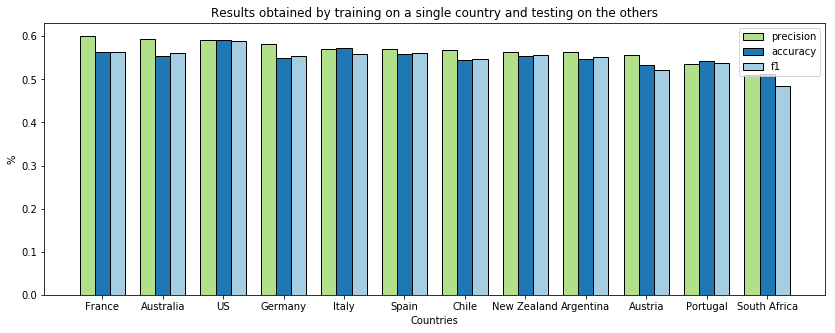

In [22]:
#plot accuracy, precision, f1 for every country (f1=weighted average of precision, recall)
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","precision","accuracy","f1"]]
temp = temp.sort_values(["precision","f1","accuracy"],ascending=False)
# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["precision"]
# Choose the height of the cyan bars
bars2 = temp["accuracy"]

bars3 = temp["f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#b2df8a", edgecolor = 'black', capsize=7, label='precision')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#1f78b4', edgecolor = 'black', capsize=7, label='accuracy')

plt.bar(r3, bars3, width = barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7, label='f1')

xs = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], xs)
plt.title("Results obtained by training on a single country and testing on the others")
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
 
# Show graphic
plt.show()


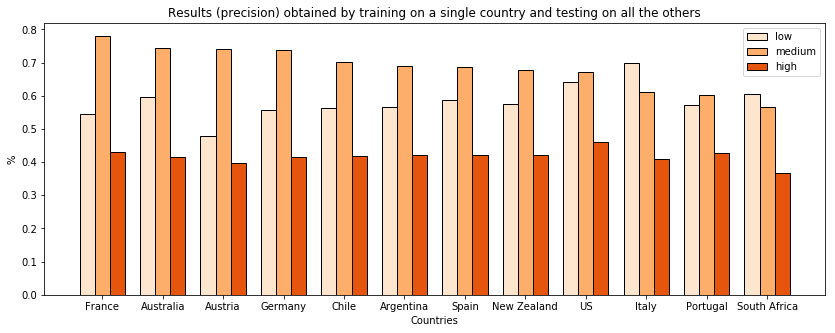

In [23]:

#plot f1 by category predicted 
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","low_prec","medium_prec","high_prec"]]
temp = temp.sort_values(["medium_prec","high_prec","low_prec"],ascending=False)
temp

# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["low_prec"]
# Choose the height of the cyan bars
bars2 = temp["medium_prec"]

bars3 = temp["high_prec"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#fee6ce", edgecolor = 'black', capsize=7, label='low')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#fdae6b', edgecolor = 'black', capsize=7, label='medium')

plt.bar(r3, bars3, width = barWidth, color = "#e6550d", edgecolor = 'black', capsize=7, label='high')

ys = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ys)
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
plt.title("Results (precision) obtained by training on a single country and testing on all the others") 
# Show graphic
plt.show()

In [24]:
#take mean of all the features used in the computations of decision tree to see the by country and understand which factors play into a country 

features = []
for col in df.columns:
    if col.startswith("feat"):
        features.append(col)
print(features)

t1 = pd.DataFrame()
t = trainedOnSingleCountry.groupby("ObjectiveCountry")
for col in features: 
    t1[col] = t[col].mean() 
t1.reset_index(inplace=True)
t1

['feat_price', 'feat_region_1', 'feat_variety', 'feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Anne Krebiehl\xa0MW', 'feat_Carrie Dykes', 'feat_Joe Czerwinski', 'feat_Kerin O’Keefe', 'feat_Lauren Buzzeo', 'feat_Paul Gregutt', 'feat_Roger Voss', 'feat_Sean P. Sullivan', 'feat_Susan Kostrzewa', 'feat_Virginie Boone', 'feat_unknown', 'feat_Alsace', 'feat_Andalucia', 'feat_Australia Other', 'feat_Burgenland', 'feat_Cachapoal Valley', 'feat_Colchagua Costa', 'feat_Colchagua Valley', 'feat_Constantia', 'feat_Dão', 'feat_Franken', 'feat_Franschhoek', 'feat_Galicia', "feat_Hawke's Bay", 'feat_Kremstal', 'feat_Loncomilla Valley', 'feat_Marlborough', 'feat_Martinborough', 'feat_Mendoza Province', 'feat_Minho', 'feat_Molina', 'feat_Mosel', 'feat_Niederösterreich', 'feat_Northern Spain', 'feat_Olifants River', 'feat_Paardeberg', 'feat_Pfalz', 'feat_Piedmont', 'feat_Port', 'feat_Provence', 'feat_Rheinhessen', 'feat_Rhône Valle

,ObjectiveCountry,feat_price,feat_region_1,feat_variety,feat_winery,feat_similarityTop3WinesByVariety,feat_word_count,feat_vintage,feat_Alexander Peartree,feat_Anne Krebiehl MW,...,feat_Südsteiermark,feat_Tasmania,feat_Tejo,feat_Traisental,feat_Trás-os-Montes,feat_Tuscany,feat_Virginia,feat_Waipara,feat_Weinviertel,feat_Österreichischer Sekt
0,Argentina,0.798689,0.000853,0.007772,0.000855,0.135962,0.048585,0.006651,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,Australia,0.734031,0.013996,0.001253,0.004062,0.091463,0.081368,0.060684,0.000000,0.000000,...,0.000000,0.000747,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,Austria,0.522418,0.000000,0.011944,0.004222,0.028293,0.310707,0.021433,0.000000,0.077812,...,0.001225,0.000000,0.000000,0.001245,0.000000,0.000000,0.000000,0.00000,0.000617,0.004469
3,Chile,0.861029,0.000000,0.005802,0.010526,0.034896,0.074646,0.008307,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
4,France,0.832017,0.005624,0.000671,0.000916,0.054742,0.096678,0.000164,0.000000,0.007085,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
5,Germany,0.755333,0.000000,0.012686,0.011167,0.094582,0.052509,0.068553,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
6,Italy,0.698216,0.002163,0.000249,0.000188,0.062927,0.207593,0.000217,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000495,0.000000,0.00000,0.000000,0.000000
7,New Zealand,0.523987,0.000000,0.004599,0.013925,0.037393,0.276652,0.112249,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00113,0.000000,0.000000
8,Portugal,0.785192,0.000000,0.029911,0.003194,0.088551,0.082261,0.007404,0.000000,0.000000,...,0.000000,0.000000,0.000214,0.000000,0.000292,0.000000,0.000000,0.00000,0.000000,0.000000
9,South Africa,0.575669,0.000000,0.008552,0.006283,0.017156,0.345668,0.014815,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


['feat_region_1', 'feat_variety', 'feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_vintage', 'feat_Mendoza Province']
[0.06095302812950402, 0.25360260293702025, 0.06136748704066445, 1.0, 0.05787130746162814, 1.0]


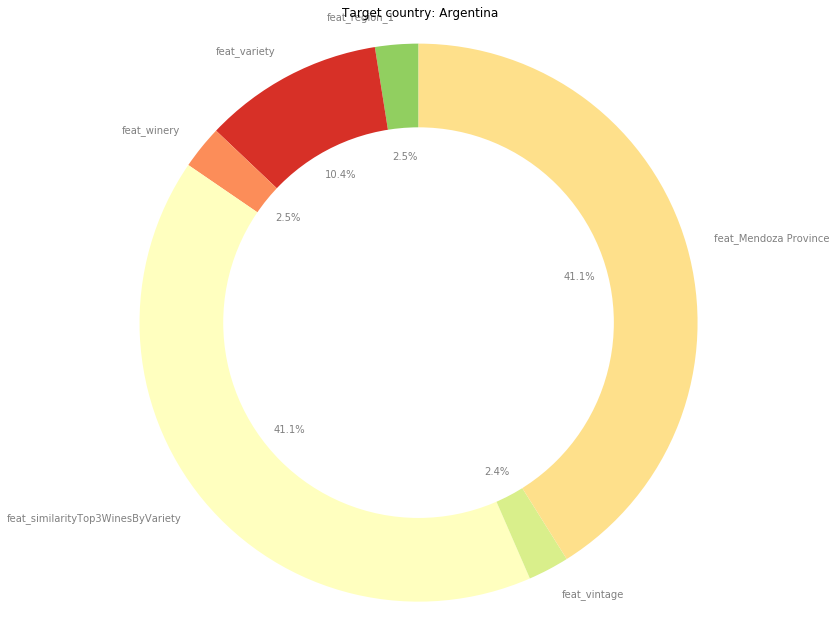

['feat_region_1', 'feat_variety', 'feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_unknown', 'feat_Australia Other', 'feat_Tasmania']
[0.9999999999999999, 0.03382213389210094, 0.2917185428922286, 0.6296216642673163, 0.09365629779421164, 0.5399415758066052, 0.014701842596917378, 1.0, 1.0]


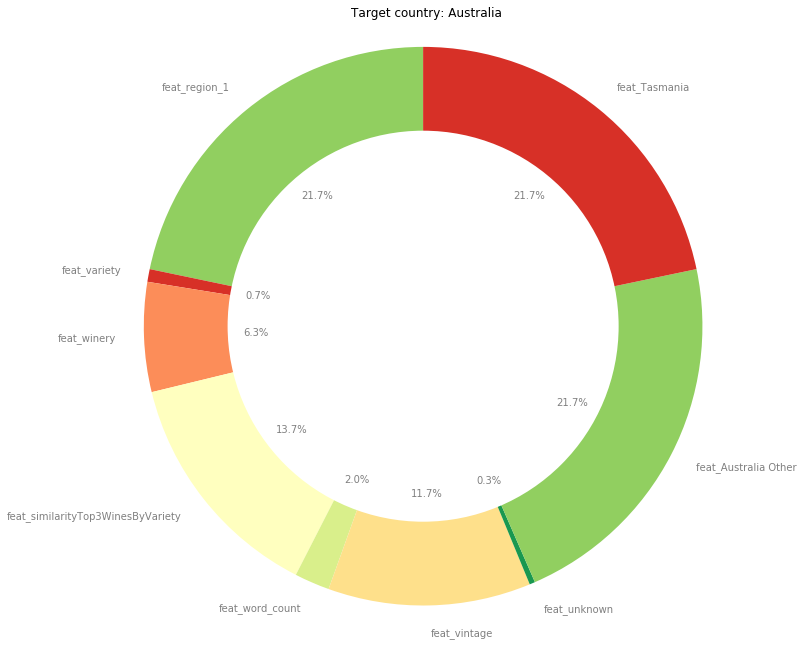

['feat_variety', 'feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Anne Krebiehl\xa0MW', 'feat_Roger Voss', 'feat_Burgenland', 'feat_Kremstal', 'feat_Niederösterreich', 'feat_Südsteiermark', 'feat_Traisental', 'feat_Weinviertel', 'feat_Österreichischer Sekt']
[0.39427887757424923, 0.3032017753255441, 0.10384291231137396, 0.748853264888481, 0.18975349398662184, 0.9999999999999999, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0]


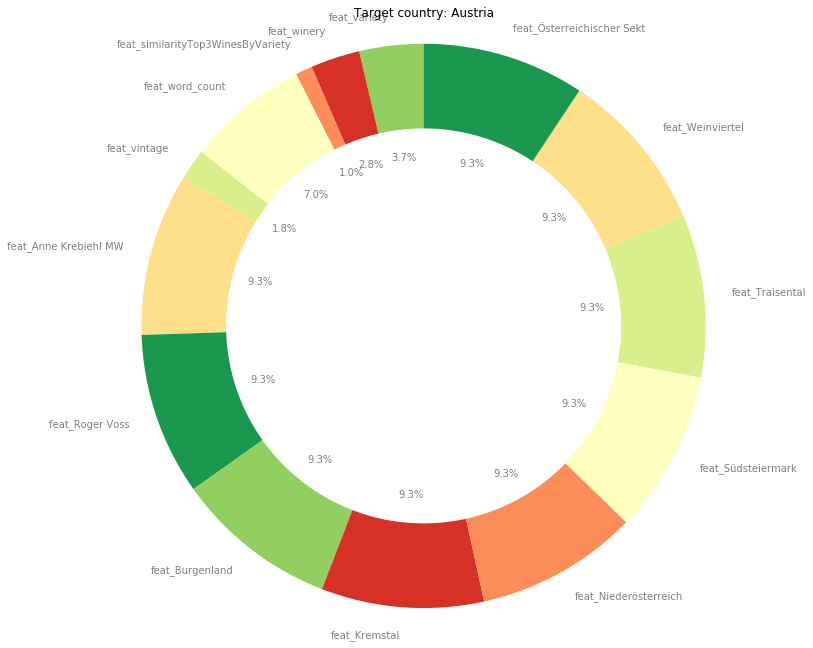

['feat_variety', 'feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Cachapoal Valley', 'feat_Colchagua Costa', 'feat_Colchagua Valley', 'feat_Loncomilla Valley', 'feat_Molina']
[0.1872122996952754, 0.7559348569356333, 0.15880030450508575, 0.07445445366390549, 0.07264652038600353, 1.0, 1.0, 1.0, 0.9999999999999999, 0.9999999999999999]


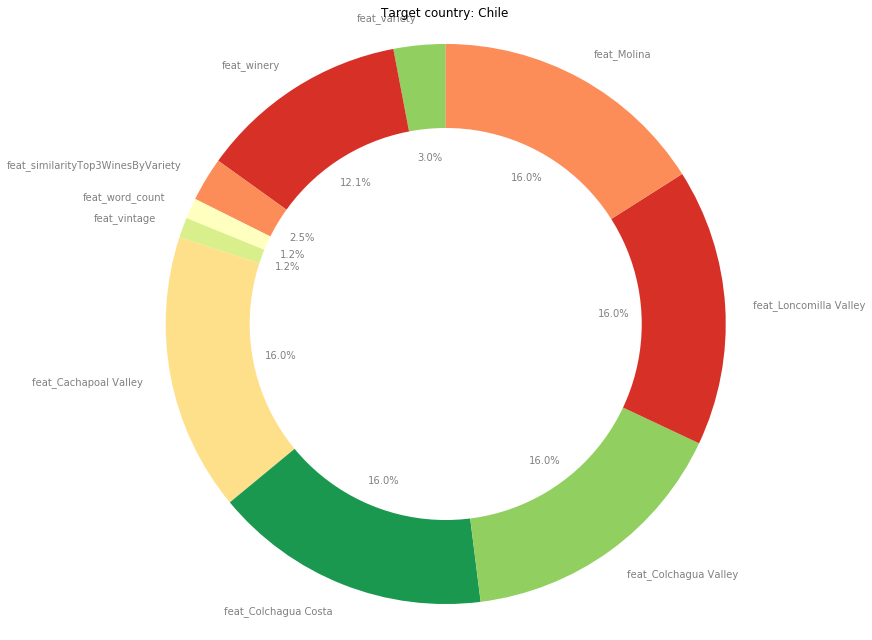

['feat_region_1', 'feat_variety', 'feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_Anne Krebiehl\xa0MW', 'feat_Roger Voss', 'feat_unknown', 'feat_Alsace', 'feat_Provence', 'feat_Rhône Valley']
[0.4018609881525026, 0.014206361724163495, 0.06574590846369151, 0.32398258268942615, 0.13739505819132308, 0.09105875193753657, 0.0338086654183485, 0.015126529654716019, 1.0, 1.0, 1.0]


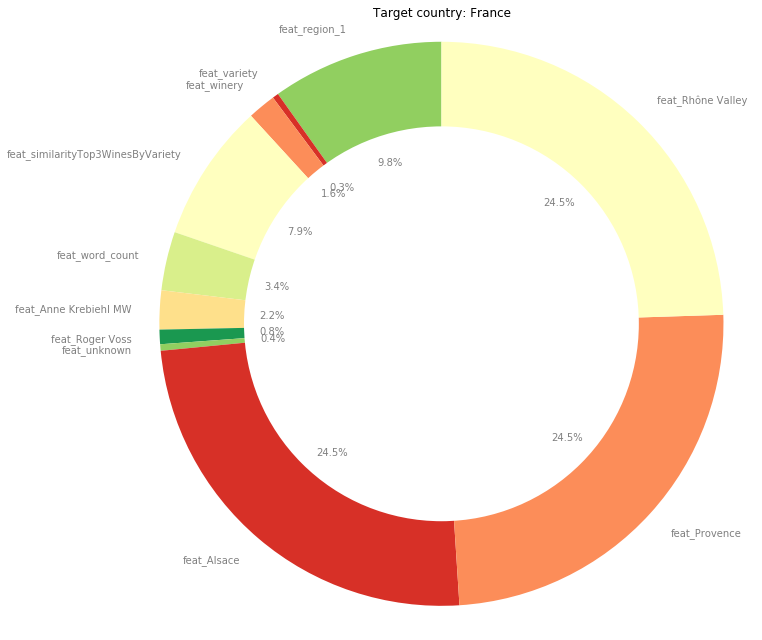

['feat_variety', 'feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Franken', 'feat_Mosel', 'feat_Pfalz', 'feat_Rheinhessen']
[0.4193009074904173, 0.8019211128323122, 0.6555835108193222, 0.011209723616841, 0.6101499563442236, 1.0, 0.9999999999999999, 1.0, 1.0]


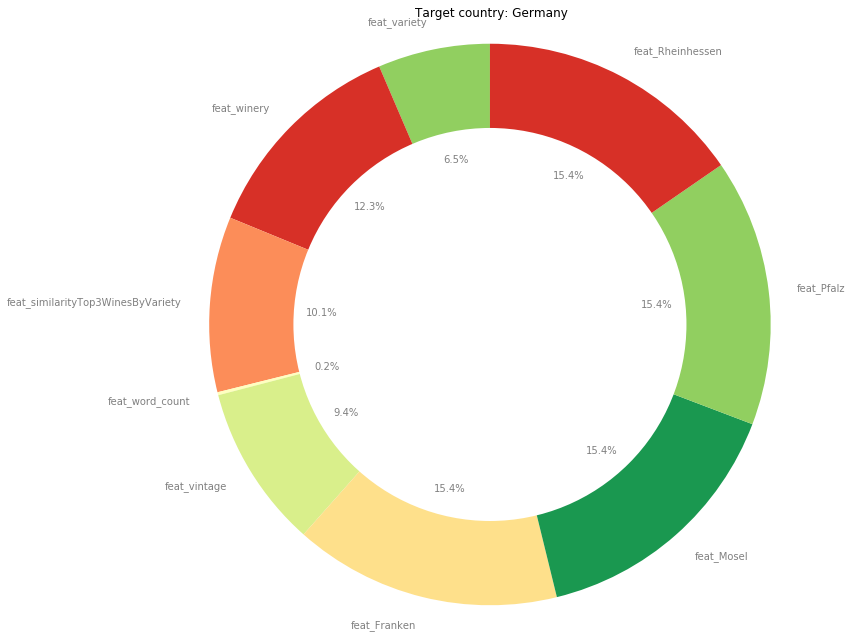

['feat_region_1', 'feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Kerin O’Keefe', 'feat_Roger Voss', 'feat_unknown', 'feat_Piedmont', 'feat_Tuscany']
[0.15451907970010398, 0.013525166616554153, 0.39211546038298756, 0.45426702444920264, 0.00047029343704719823, 1.0, 0.013701562010423036, 0.04367046475770055, 0.9999999999999999, 1.0]


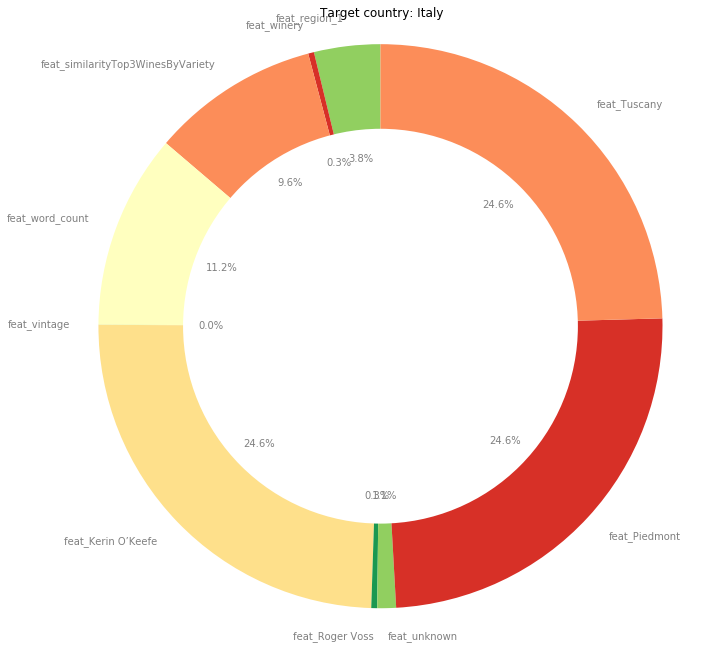

['feat_variety', 'feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Joe Czerwinski', 'feat_unknown', "feat_Hawke's Bay", 'feat_Marlborough', 'feat_Martinborough', 'feat_Waipara']
[0.14664025753991827, 1.0, 0.17958901115206738, 0.6515628836009205, 1.0000000000000002, 1.0, 0.07681896080583782, 1.0, 1.0, 0.9999999999999999, 1.0]


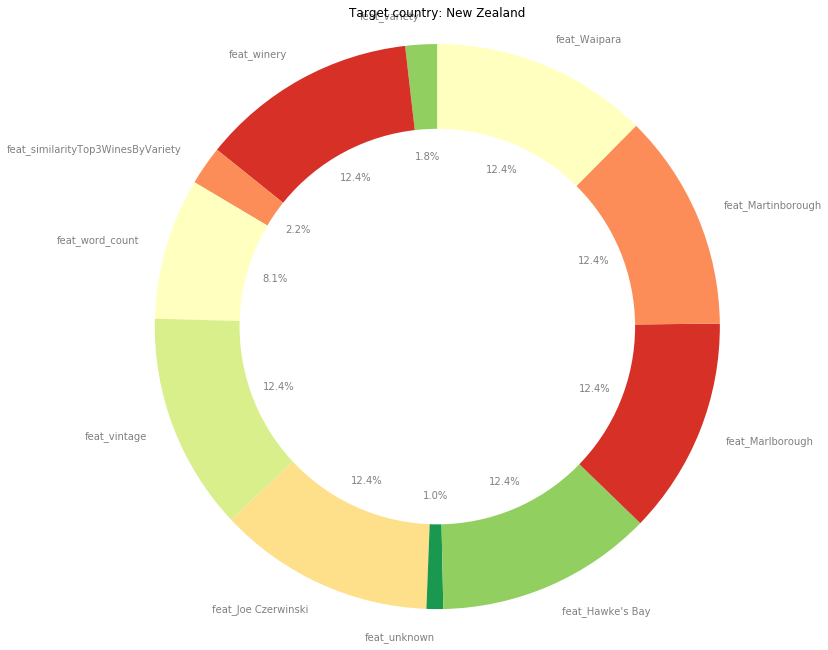

['feat_variety', 'feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Roger Voss', 'feat_Dão', 'feat_Minho', 'feat_Port', 'feat_Tejo', 'feat_Trás-os-Montes']
[1.0, 0.22934141046650594, 0.6053888650526968, 0.09620884248671269, 0.06459068807355228, 0.058994118324731136, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0]


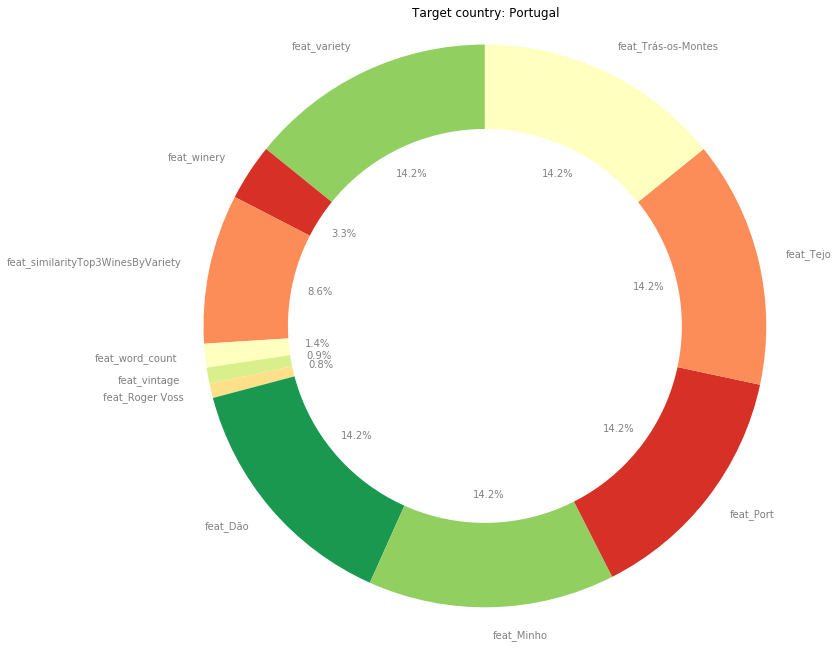

['feat_variety', 'feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Lauren Buzzeo', 'feat_Susan Kostrzewa', 'feat_unknown', 'feat_Constantia', 'feat_Franschhoek', 'feat_Olifants River', 'feat_Paardeberg', 'feat_Stellenbosch']
[0.27990983563286664, 0.45123223292057696, 0.011153789864707497, 0.8487322487478033, 0.1307072535637191, 1.0, 1.0, 0.1449809687811331, 0.9999999999999999, 1.0, 0.9999999999999999, 1.0, 0.9999999999999999]


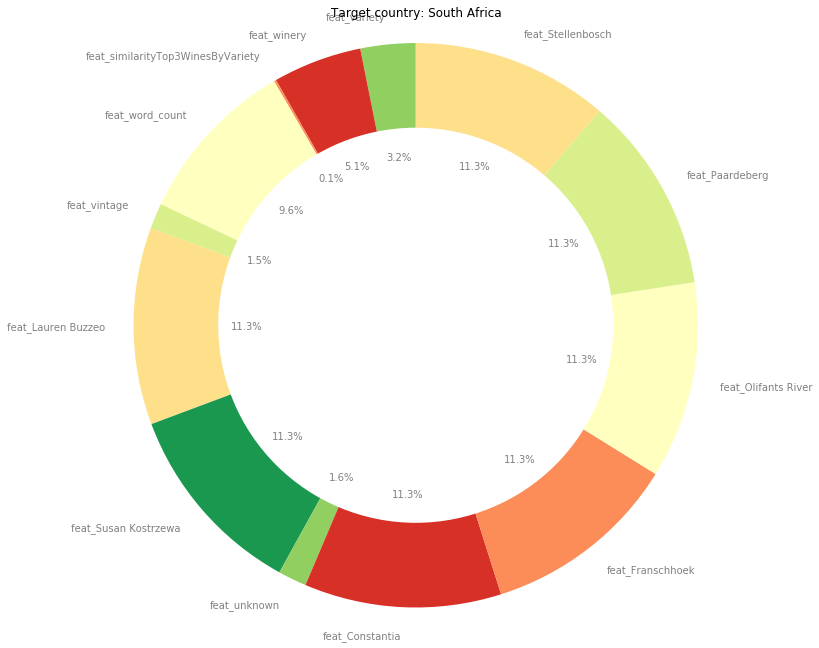

['feat_region_1', 'feat_variety', 'feat_winery', 'feat_similarityTop3WinesByVariety', 'feat_word_count', 'feat_vintage', 'feat_Andalucia', 'feat_Galicia', 'feat_Northern Spain']
[0.2631559680698804, 0.25441549280279047, 0.2940108524648471, 0.4044813587469091, 0.09501300657116088, 0.049882685474943164, 0.9999999999999999, 1.0, 1.0]


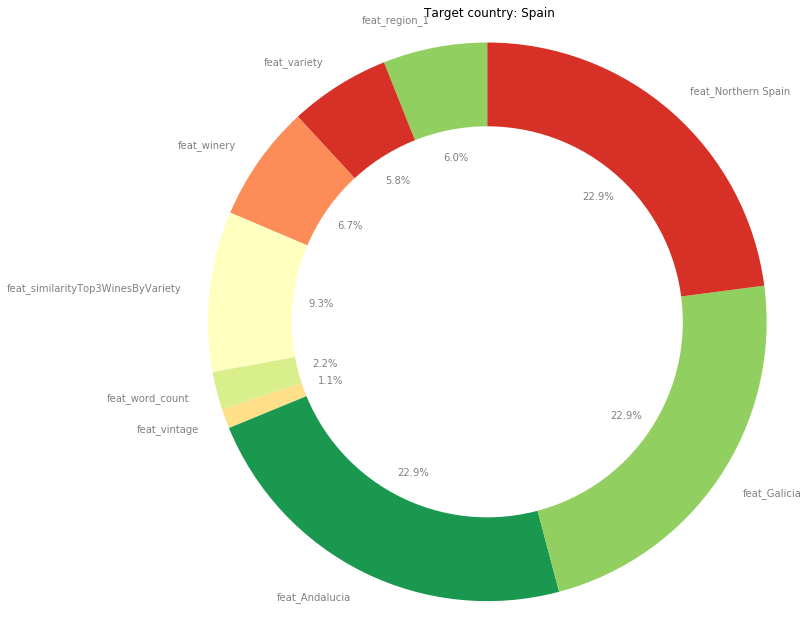

['feat_variety', 'feat_word_count', 'feat_vintage', 'feat_Alexander Peartree', 'feat_Carrie Dykes', 'feat_Paul Gregutt', 'feat_Sean P. Sullivan', 'feat_Virginie Boone', 'feat_unknown', 'feat_Virginia']
[0.004623540085735536, 1.0, 0.06013858845923022, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999]


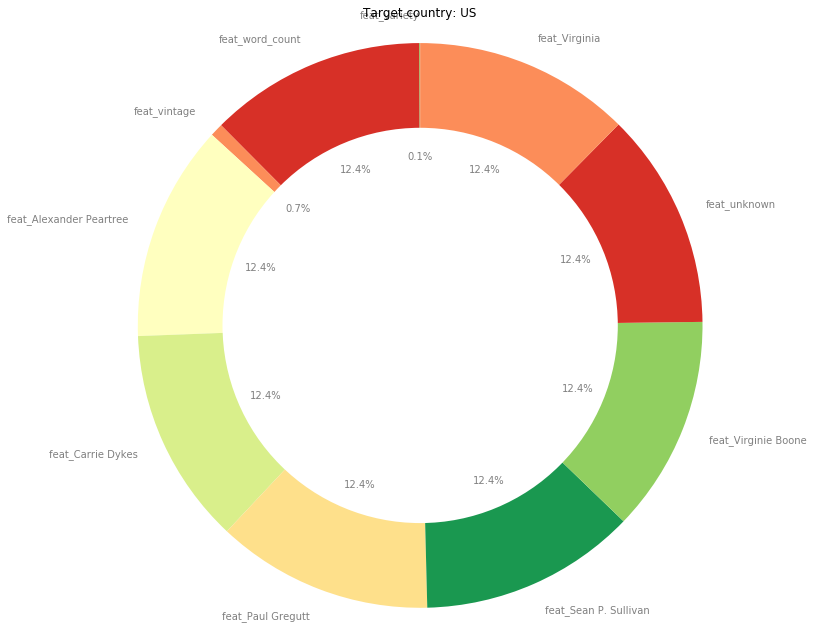

In [25]:
from sklearn import preprocessing

t2 = t1.drop(["ObjectiveCountry"],axis=1)
x = t2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
t3 = pd.DataFrame(x_scaled,columns=t2.columns)



import matplotlib.pyplot as plt

for idx,row in t3.iterrows():
    toPlot = []
    values = []
    for col in t3.columns:  
        if row[col] != 0 and col != "ObjectiveCountry" and col != "feat_price":    #ignore price
            toPlot.append(col)
            values.append(row[col])
    print(toPlot)
    print(values)

    fig, ax = plt.subplots(figsize = (9, 9))
    # create data
    names= toPlot  
    size= values
    colors =['#91cf60','#d73027','#fc8d59','#ffffbf','#d9ef8b','#fee08b','#1a9850']
    # Create a circle for the center of the plot
    my_circle=plt.Circle((0,0), 0.70, fc='white')
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    patches, texts, autotexts = ax.pie(size, labels=names, autopct='%1.1f%%', startangle=90,colors=colors)
    for text in texts:
        text.set_color('grey')
    for autotext in autotexts:
        autotext.set_color('grey')
    
    ax.axis('equal')  

    plt.tight_layout()
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

[['feat_vintage', 0.05787130746162814], ['feat_region_1', 0.06095302812950402], ['feat_winery', 0.06136748704066445], ['feat_variety', 0.25360260293702025], ['feat_price', 0.8287088188102789], ['feat_similarityTop3WinesByVariety', 1.0], ['feat_Mendoza Province', 1.0]]


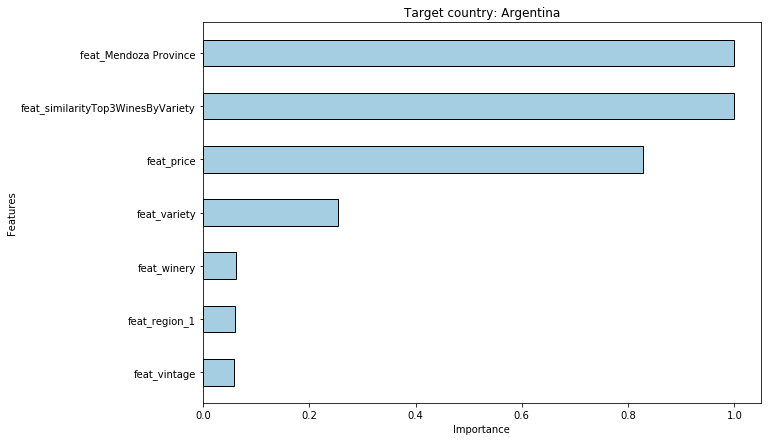

[['feat_unknown', 0.014701842596917378], ['feat_variety', 0.03382213389210094], ['feat_word_count', 0.09365629779421164], ['feat_winery', 0.2917185428922286], ['feat_vintage', 0.5399415758066052], ['feat_similarityTop3WinesByVariety', 0.6296216642673163], ['feat_price', 0.6510499901766287], ['feat_region_1', 0.9999999999999999], ['feat_Australia Other', 1.0], ['feat_Tasmania', 1.0]]


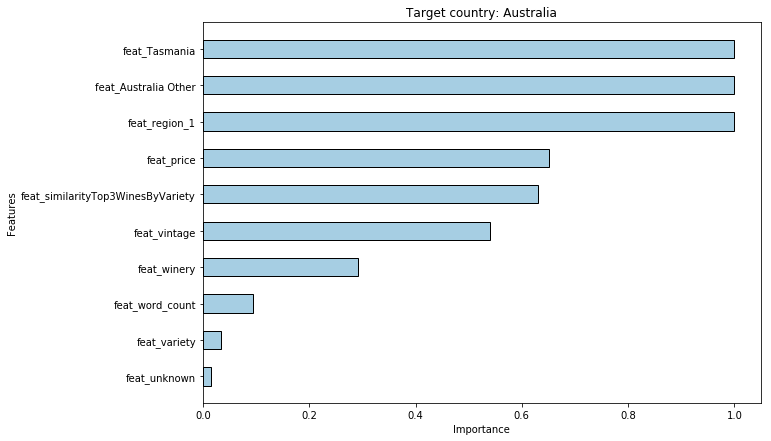

[['feat_price', 0.06960442698192537], ['feat_similarityTop3WinesByVariety', 0.10384291231137396], ['feat_vintage', 0.18975349398662184], ['feat_winery', 0.3032017753255441], ['feat_variety', 0.39427887757424923], ['feat_word_count', 0.748853264888481], ['feat_Anne Krebiehl\xa0MW', 0.9999999999999999], ['feat_Kremstal', 0.9999999999999999], ['feat_Roger Voss', 1.0], ['feat_Burgenland', 1.0], ['feat_Niederösterreich', 1.0], ['feat_Südsteiermark', 1.0], ['feat_Traisental', 1.0], ['feat_Weinviertel', 1.0], ['feat_Österreichischer Sekt', 1.0]]


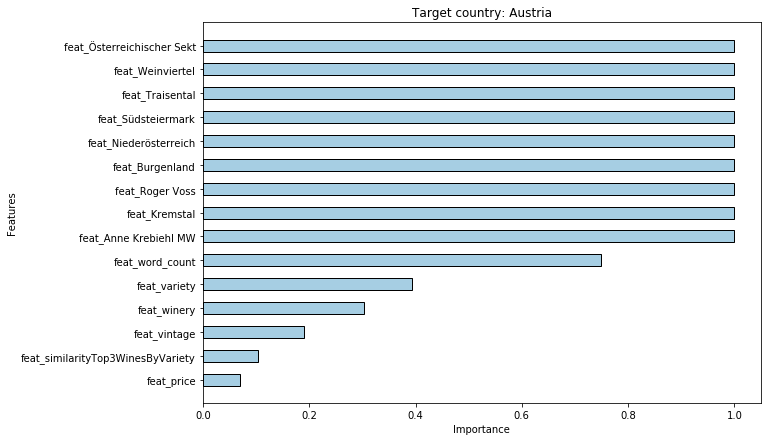

[['feat_vintage', 0.07264652038600353], ['feat_word_count', 0.07445445366390549], ['feat_similarityTop3WinesByVariety', 0.15880030450508575], ['feat_variety', 0.1872122996952754], ['feat_winery', 0.7559348569356333], ['feat_Loncomilla Valley', 0.9999999999999999], ['feat_Molina', 0.9999999999999999], ['feat_price', 1.0], ['feat_Cachapoal Valley', 1.0], ['feat_Colchagua Costa', 1.0], ['feat_Colchagua Valley', 1.0]]


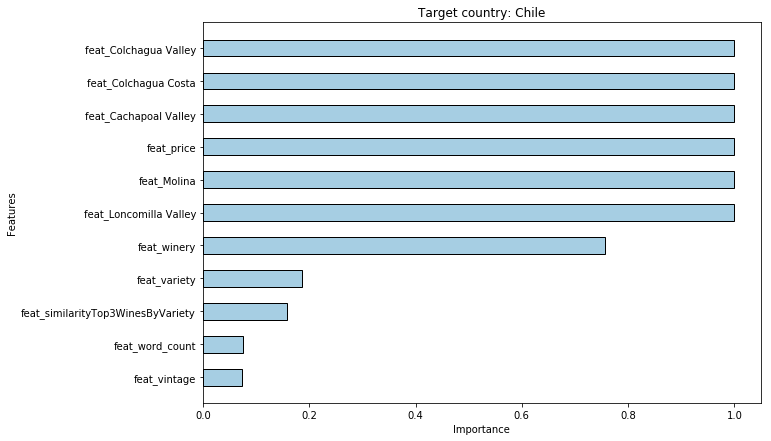

[['feat_variety', 0.014206361724163495], ['feat_unknown', 0.015126529654716019], ['feat_Roger Voss', 0.0338086654183485], ['feat_winery', 0.06574590846369151], ['feat_Anne Krebiehl\xa0MW', 0.09105875193753657], ['feat_word_count', 0.13739505819132308], ['feat_similarityTop3WinesByVariety', 0.32398258268942615], ['feat_region_1', 0.4018609881525026], ['feat_price', 0.920283351427492], ['feat_Alsace', 1.0], ['feat_Provence', 1.0], ['feat_Rhône Valley', 1.0]]


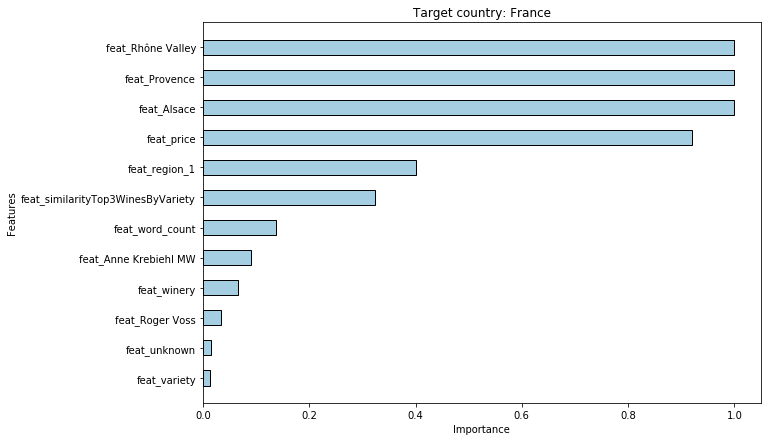

[['feat_word_count', 0.011209723616841], ['feat_variety', 0.4193009074904173], ['feat_vintage', 0.6101499563442236], ['feat_similarityTop3WinesByVariety', 0.6555835108193222], ['feat_price', 0.7095804875264453], ['feat_winery', 0.8019211128323122], ['feat_Mosel', 0.9999999999999999], ['feat_Franken', 1.0], ['feat_Pfalz', 1.0], ['feat_Rheinhessen', 1.0]]


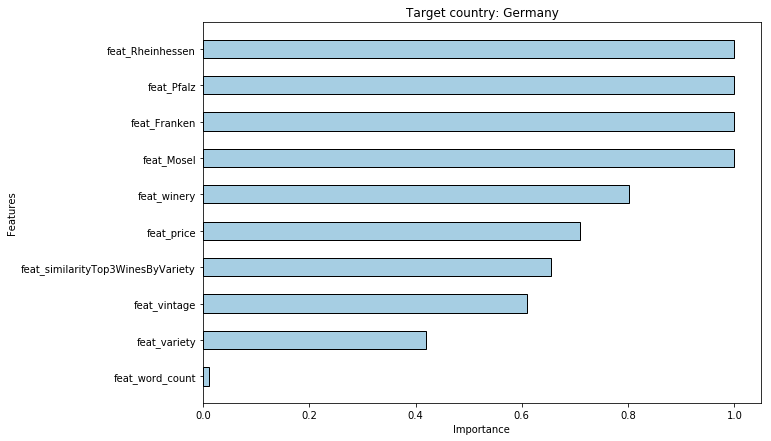

[['feat_vintage', 0.00047029343704719823], ['feat_winery', 0.013525166616554153], ['feat_Roger Voss', 0.013701562010423036], ['feat_unknown', 0.04367046475770055], ['feat_region_1', 0.15451907970010398], ['feat_similarityTop3WinesByVariety', 0.39211546038298756], ['feat_word_count', 0.45426702444920264], ['feat_price', 0.5526411506995998], ['feat_Piedmont', 0.9999999999999999], ['feat_Kerin O’Keefe', 1.0], ['feat_Tuscany', 1.0]]


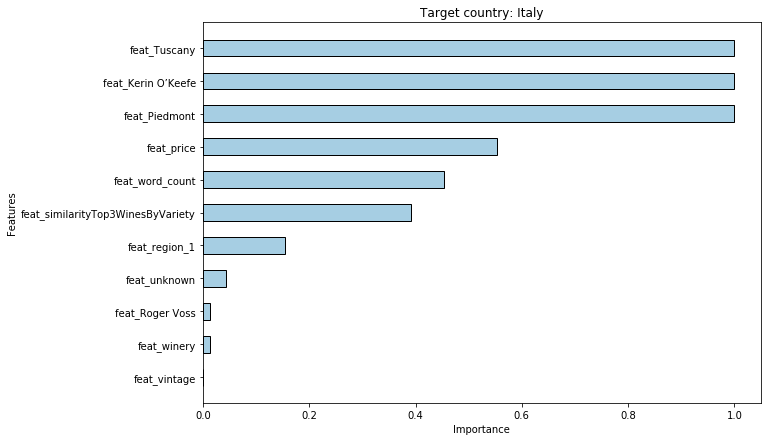

[['feat_price', 0.07391489473577106], ['feat_unknown', 0.07681896080583782], ['feat_variety', 0.14664025753991827], ['feat_similarityTop3WinesByVariety', 0.17958901115206738], ['feat_word_count', 0.6515628836009205], ['feat_Martinborough', 0.9999999999999999], ['feat_winery', 1.0], ['feat_Joe Czerwinski', 1.0], ["feat_Hawke's Bay", 1.0], ['feat_Marlborough', 1.0], ['feat_Waipara', 1.0], ['feat_vintage', 1.0000000000000002]]


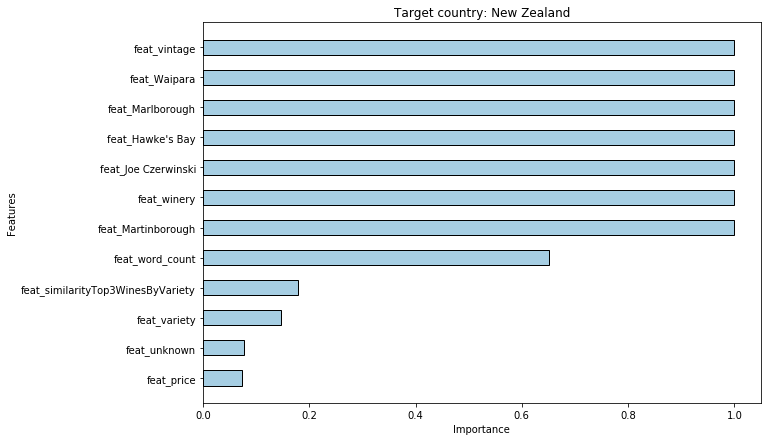

[['feat_Roger Voss', 0.058994118324731136], ['feat_vintage', 0.06459068807355228], ['feat_word_count', 0.09620884248671269], ['feat_winery', 0.22934141046650594], ['feat_similarityTop3WinesByVariety', 0.6053888650526968], ['feat_price', 0.7916215148600072], ['feat_Minho', 0.9999999999999999], ['feat_variety', 1.0], ['feat_Dão', 1.0], ['feat_Port', 1.0], ['feat_Tejo', 1.0], ['feat_Trás-os-Montes', 1.0]]


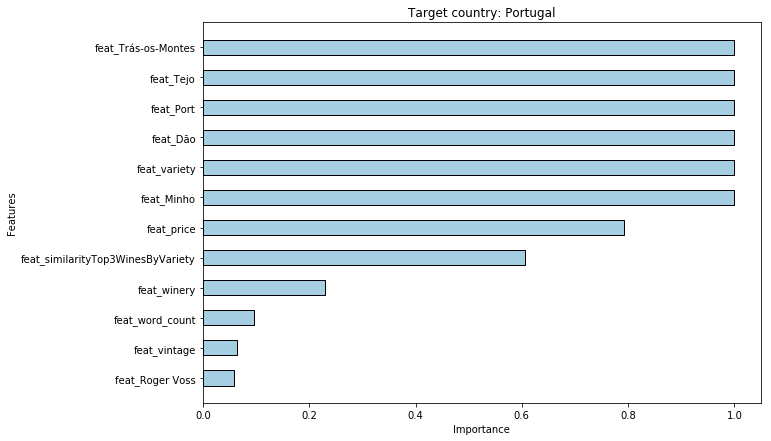

[['feat_similarityTop3WinesByVariety', 0.011153789864707497], ['feat_vintage', 0.1307072535637191], ['feat_unknown', 0.1449809687811331], ['feat_price', 0.2159202554353139], ['feat_variety', 0.27990983563286664], ['feat_winery', 0.45123223292057696], ['feat_word_count', 0.8487322487478033], ['feat_Constantia', 0.9999999999999999], ['feat_Olifants River', 0.9999999999999999], ['feat_Stellenbosch', 0.9999999999999999], ['feat_Lauren Buzzeo', 1.0], ['feat_Susan Kostrzewa', 1.0], ['feat_Franschhoek', 1.0], ['feat_Paardeberg', 1.0]]


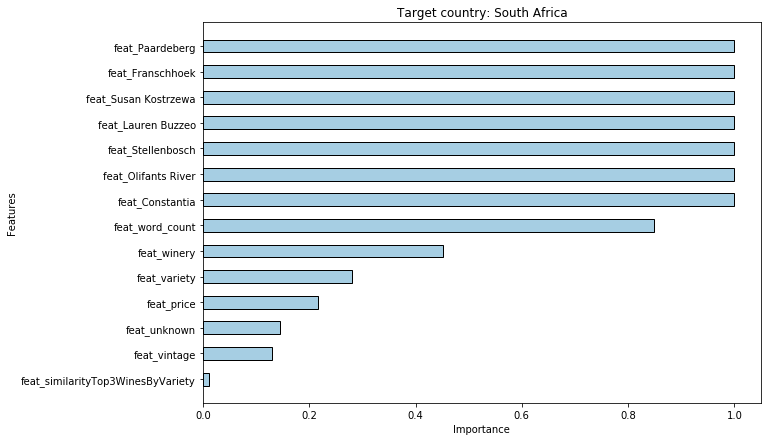

[['feat_vintage', 0.049882685474943164], ['feat_word_count', 0.09501300657116088], ['feat_variety', 0.25441549280279047], ['feat_region_1', 0.2631559680698804], ['feat_winery', 0.2940108524648471], ['feat_similarityTop3WinesByVariety', 0.4044813587469091], ['feat_price', 0.8978712666977215], ['feat_Andalucia', 0.9999999999999999], ['feat_Galicia', 1.0], ['feat_Northern Spain', 1.0]]


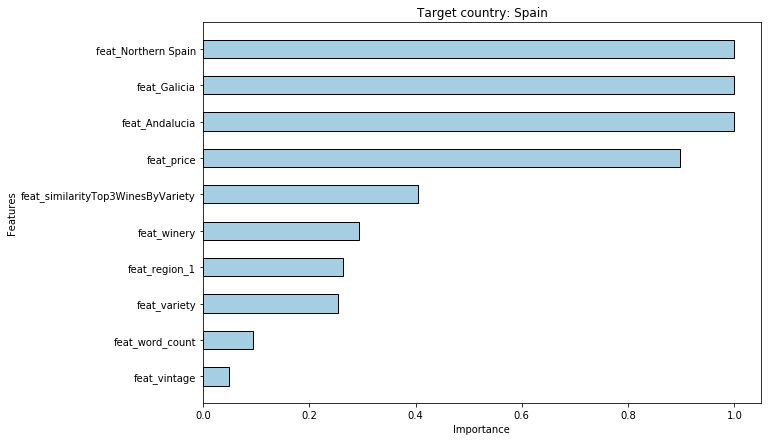

[['feat_variety', 0.004623540085735536], ['feat_vintage', 0.06013858845923022], ['feat_Virginia', 0.9999999999999999], ['feat_word_count', 1.0], ['feat_Alexander Peartree', 1.0], ['feat_Carrie Dykes', 1.0], ['feat_Paul Gregutt', 1.0], ['feat_Sean P. Sullivan', 1.0], ['feat_Virginie Boone', 1.0], ['feat_unknown', 1.0]]


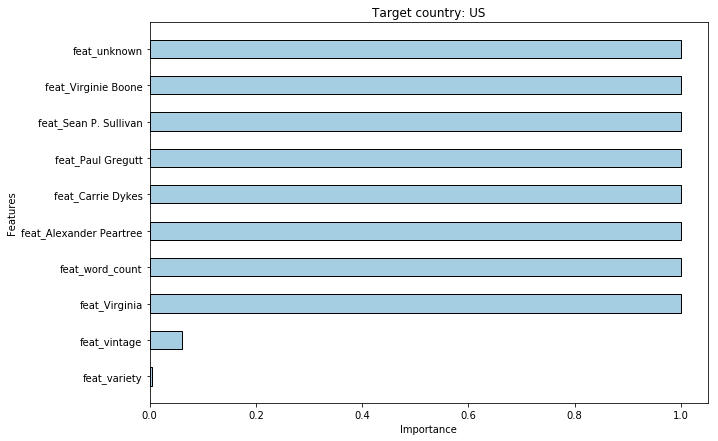

In [26]:
for idx,row in t3.iterrows():
    both = []
    for col in t3.columns:
        if row[col] != 0 and col != "ObjectiveCountry": #THIS TAKES INTO ACCOUNT EVEN PRICE WHICH IS A LOT LESS IMPORTANT COMPARED TO THE FIRST APPROACH
            both.append([col,row[col]])
    #print(toPlot)
    #print(values)
    
    from operator import itemgetter
    both = sorted(both, key=itemgetter(1))
    print(both)
    
    toPlot = []
    values = []    
    for el in both:
        toPlot.append(el[0])
        values.append(el[1])
    
    # width of the bars
    barWidth = 0.5
    
    # Choose the height of the blue bars
    bars1 = values

    # The x position of bars
    r1 = np.arange(len(toPlot))
    fig, ax = plt.subplots(figsize = (10, 7))

    # Create blue bars
    plt.barh(r1, bars1, height=barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7)
    #plt.bar(r1,bars1,width = barWidth..)
    ys = toPlot
    # general layout
    #plt.xticks([r for r in range(len(bars1))], ys,rotation='vertical')
    #plt.yticks([r for r in range(len(bars1))], ys,rotation='vertical')
    plt.yticks([r for r in range(len(bars1))], ys)
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    plt.ylabel('Features')
    plt.xlabel("Importance")
    # Show graphic
    plt.show()

# DUMMY (train one country, test others)

In [ ]:
for c in countries:
    X = wine_base
    wine_base["category"] = Y
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    X_train = X[X["country"] == c]
    y_train = list(X_train["category"])
    print(c +" must be the only one in the training set " + str(X_train["country"].unique().tolist()))
    print(str(X_train["country"].unique().tolist()) + "country in the training set")
    X_train.drop(["country","category"],axis=1,inplace=True)

    X_test = X[X["country"] != c]
    y_test = X_test["category"]
    print(str(X_test["country"].unique().tolist()) + "country in the test set")
    X_test.drop(["country","category"],axis=1,inplace=True)
   
    classifier = DummyClassifier("stratified")
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)  
    acc = accuracy_score(y_test,y_pred)
    weightedPrec = precision_score(y_test,y_pred,average="weighted")
    print("COUNTRY " + c + classification_report(y_test, y_pred, target_names=labels))
